# Analysis of the Box-Counting Dimension of Metal Nanoparticles

This notebook contains the results from the analysis of the box-counting dimensions, $D_B$, computed for metal nanoparticles, in attempt to explore the potential usefulness of $D_B$ as a catalytic performance indicator.

The results are computed using [Sphractal](https://github.com/jon-ting/sphractal), a Python package for the estimation of the fractal dimension of the surfaces of computational atomistic objects (where the atomic coordinates are known precisely) via box-counting approaches.

## Outline

[Notebook Setups](#setup)

[Correlation with Box-Counting Dimension and Catalytic Activity](#catact)

[Comparison between Monometallic Nanoparticles of Different Elements under Similar Conditions](#mnps)

[Comparison between Bimetallic Nanoparticles Trajectories](#bnps)

<a id='setup'></a>
## Notebook Setups

In [5]:
# Import relevant libraries
from os import listdir
import pickle
import warnings

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sphractal

from natsort import natsorted
from sphractal import readInp, findNN

# Print package versions for reproducibility
print('Versions of imported libraries:')
print(f"  matplotlib: {mpl.__version__}")
print(f"  numpy: {np.__version__}")
print(f"  pandas: {pd.__version__}")
print(f"  seaborn: {sns.__version__}")
print(f"  sphractal: {sphractal.__version__}")

Versions of imported libraries:
  matplotlib: 3.7.2
  numpy: 1.24.4
  pandas: 2.0.3
  seaborn: 0.12.2
  sphractal: 0.22.2


Below are some general settings for plotting figures:

In [6]:
# Settings for figures
sns.set_theme(context='paper', style='ticks', palette='colorblind', font='sans-serif', font_scale=1, color_codes=True, rc=None)  # Options are: {paper, notebook, talk, poster}
figSize, dpi, fontSize, labelSize = (3.5, 2.5), None, 'medium', 'small'
legendSize, lineWidth, markerSize = 'x-small', 1, 3
# SMALL_SIZE, MEDIUM_SIZE, LARGE_SIZE, TITLE_SIZE = 8, 10, 12, 14
# plt.rc('font', size=LARGE_SIZE)  # controls default text sizes
# plt.rc('axes', titlesize=TITLE_SIZE)  # fontsize of the axes title
# plt.rc('axes', labelsize=LARGE_SIZE)  # fontsize of the x and y labels
# plt.rc('xtick', labelsize=LARGE_SIZE)  # fontsize of the tick labels
# plt.rc('ytick', labelsize=LARGE_SIZE)  # fontsize of the tick labels
# plt.rc('legend', fontsize=LARGE_SIZE)  # legend fontsize
# plt.rc('figure', titlesize=TITLE_SIZE)  # fontsize of the figure title

Some handy general functions:

In [7]:
def readPickle(picklePath):
    with open(picklePath, 'rb') as f: 
        df = pickle.load(f)
    df['rangeLenVX'] = df.apply(lambda f: f['maxLenVX'] - f['minLenVX'], axis=1)
    df['rangeLenEX'] = df.apply(lambda f: f['maxLenEX'] - f['minLenEX'], axis=1)
    return df

<a id='catact'></a>
## Correlation between Box-Counting Dimension and Catalytic Activity

Here we aim to investigate the relationship between the known catalytic activity exhibited by nanoparticles enclosed by certain surface facets, and their fractal dimensions as estimated by their box-counting dimensions $D_B$, which quantify the roughness of their atomistic surfaces.

### Data Set

The data used here are obtained from collections of atomic coordinates of simulated nanoparticles generated for machine learning studies. Note that each conformation of nanoparticle has been energy-minimised.

The initial shapes of the bimetallic nanoparticles are chosen to match a few of those investigated and reported in [Bimetallic Pt–Pd nano-catalyst: size, shape and composition matter](https://doi.org/10.1088/1361-6528/ab1759) by Mendoza-Pérez and Guisbiers in 2019, namely tetrahedron (`TH`), octahedron (`OT`), cube (`CU`), and rhombic dodecahedron (`RD`). The publication indicated that `TH` and `CU` are the most catalytically active shapes, in accordance with the previous theoretical and experimental findings.

### Identifying Suitable Nanoparticle Sizes

To minimise the impact of corners and edges of the nanoparticles on their $D_B$ values, we need to first determine the nanoparticle size when the influences of the corners and edges become negligible. Here we examine the change in the proportion of each surface atom type as the size of the nanoparticles of different shapes increases. We generated a set of atomic coordinates of simulated palladium nanoparticles of different sizes (ranging from 3-100 nm) with three particular shapes:
- cube (`CU`), enclosed by `{100}` facets, 
- rhombic dodecahedron (`RD`), enclosed by `{110}` facets, and 
- octahedron (`OT`, enclosed by `{111}` facets.

The type of surface atom is determined by their coordination numbers (CNs)*, with the rules listed below:
- `CU`:
    - corner $\in$ {3}
    - edge $\in$ {5}
    - facet/terrace $\in$ {8}
- `OT`:
    - corner $\in$ {4}
    - edge $\in$ {7}
    - facet/terrace $\in$ {9}
- `RD`:
    - corner $\in$ {3, 4}
    - edge $\in$ {5, 10}
    - facet/terrace $\in$ {7, 11}

*\*P.S. For the readers without chemistry background, coordination numbers simply refer to the number of neighbouring atoms.*

In [8]:
# Variables to distinguish between different surface characteristics and nanoparticle sizes
surfAtomTypeCNs = {'CU': {'corner': {3}, 'edge': {5}, 'terrace': {8}},
                   'OT': {'corner': {4}, 'edge': {7}, 'terrace': {9}},
                   'RD': {'corner': {3, 4}, 'edge': {5, 10}, 'terrace': {7, 11}}}
npShapeDiametersDict = {'CU': [12, 16, 19, 23, 31, 35, 39, 47, 51, 58, 70, 82, 89, 101, 
                               121, 140, 159, 179, 198, 249, 300, 350, 401, 451],
                        'OT': [12, 16, 19, 23, 31, 35, 39, 47, 51, 58, 70, 82, 89, 101, 
                               121, 140, 159, 179, 198, 249, 300, 350, 401, 451, 502, 599, 700, 801, 899, 1000, 1101, 1198], 
                        'RD': [16, 23, 31, 39, 47, 62, 70, 78, 93, 101,
                               117, 140, 163, 179, 202, 249, 303, 350, 397, 451, 498, 599, 700, 801]}

In [9]:
# Compute the percentage of each surface characteristics over all surface atoms (this was done on a high-performance computing cluster, this cell was commented out as it's too computationally expensive for usual laptops)
# percSurfAtoms = {'CU': {'corner': [], 'edge': [], 'terrace': [], 'numSurfAtoms': []},
#                  'OT': {'corner': [], 'edge': [], 'terrace': [], 'numSurfAtoms': []},
#                  'RD': {'corner': [], 'edge': [], 'terrace': [], 'numSurfAtoms': []}}
# for fName in natsorted(listdir('atomTypeProportion')):
#     if 'xyz' not in fName: continue
#     # if int(fName[2:-6]) > 451: continue
    
#     print(f"  {fName}")
#     atomsEle, atomsRad, atomsXYZ, maxRange, minXYZ, maxXYZ = readInp(f'atomTypeProportion/{fName}', radType='atomic')
#     atomsNeighIdxsPadded, atomsAvgBondLen = findNN(atomsRad, atomsXYZ, minXYZ, maxXYZ, atomsRad.max(), 1.0, calcBL=True)

#     shape = fName[-6:-4]
#     numSurfAtom, numCorner, numEdge, numTerrace = 0, 0, 0, 0
#     for atomNeighIdxsPadded in atomsNeighIdxsPadded:
#         numNeigh = len(atomNeighIdxsPadded[atomNeighIdxsPadded > -1])
#         if numNeigh in surfAtomTypeCNs[shape]['corner']:
#             numCorner += 1
#         elif numNeigh in surfAtomTypeCNs[shape]['edge']:
#             numEdge += 1
#         elif numNeigh in surfAtomTypeCNs[shape]['terrace']:
#             numTerrace += 1
#         if numNeigh != 12: 
#             numSurfAtom += 1
    
#     if shape == 'CU':
#         if numCorner < 8:
#             numDiff = 8 - numCorner
#             numCorner += numDiff
#             numSurfAtom += numDiff
#     elif shape == 'RD':
#         if numCorner < 14:
#             numDiff = 14 - numCorner
#             numCorner += numDiff
#             numSurfAtom += numDiff
    
#     percSurfAtoms[shape]['numSurfAtoms'].append(numSurfAtom)
#     percSurfAtoms[shape]['corner'].append(numCorner / numSurfAtom * 100)
#     percSurfAtoms[shape]['edge'].append(numEdge / numSurfAtom * 100)
#     percSurfAtoms[shape]['terrace'].append(numTerrace / numSurfAtom * 100)

# with open('percSurfAtoms.pickle', 'wb') as f:
#     pickle.dump(percSurfAtoms, f)

In [10]:
# Load box-counting dimension results computed
with open('data/percSurfAtoms.pickle', 'rb') as f:
    percSurfAtoms = pickle.load(f)

In [11]:
# Percentage of All Surface Atom Types For All Three Shapes in Separate Plots
# fig, axes = plt.subplots(1, 3, figsize=(9, 3.5), sharey=True, dpi=dpi)
# axes[0].plot(npShapeDiametersDict['CU'], percSurfAtoms['CU']['corner'])  #, linewidth=3, linestyle='solid', marker='x')
# axes[0].plot(npShapeDiametersDict['CU'], percSurfAtoms['CU']['edge'])
# axes[0].plot(npShapeDiametersDict['CU'], percSurfAtoms['CU']['terrace'])
# axes[0].axhline(95, linestyle='--', color=sns.color_palette('colorblind')[3])
# axes[0].axhline(99, linestyle='--', color=sns.color_palette('colorblind')[4])
# axes[0].set_ylabel('Percentage of atom type on surface (%)')
# axes[0].set_title('Cube')

# axes[1].plot(npShapeDiametersDict['OT'], percSurfAtoms['OT']['corner'])
# axes[1].plot(npShapeDiametersDict['OT'], percSurfAtoms['OT']['edge'])
# axes[1].plot(npShapeDiametersDict['OT'], percSurfAtoms['OT']['terrace'])
# axes[1].axhline(95, linestyle='--', color=sns.color_palette('colorblind')[3])
# axes[1].axhline(99, linestyle='--', color=sns.color_palette('colorblind')[4])
# axes[1].set_xlabel(r'Nanoparticle diameter ($\AA$)')
# axes[1].set_title('Octahedron')

# axes[2].plot(npShapeDiametersDict['RD'], percSurfAtoms['RD']['corner'])
# axes[2].plot(npShapeDiametersDict['RD'], percSurfAtoms['RD']['edge'])
# axes[2].plot(npShapeDiametersDict['RD'], percSurfAtoms['RD']['terrace'])
# axes[2].axhline(95, linestyle='--', color=sns.color_palette('colorblind')[3])
# axes[2].axhline(99, linestyle='--', color=sns.color_palette('colorblind')[4])
# axes[2].set_title('Rhombic Dodecahedron')

# fig.legend(['corner', 'edge', 'terrace', '95%', '99%'], loc='lower center', bbox_to_anchor=(0.53, -0.06), ncol=5)
# plt.tight_layout()
# plt.savefig('figures/surfAtomPerc.png')

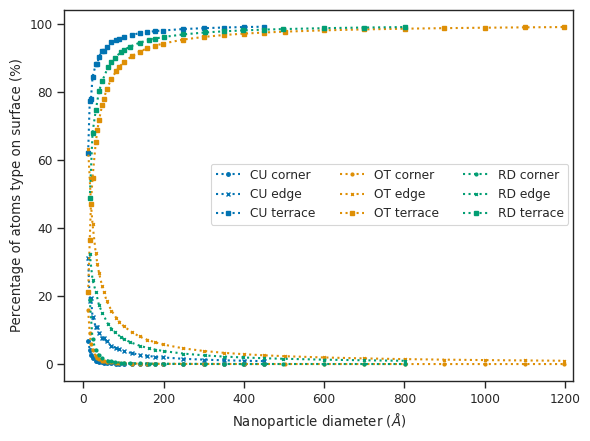

In [12]:
# Percentage of All Surface Atom Types For All Three Shapes in a Plot
fig, ax = plt.subplots(figsize=(6, 4.5), dpi=dpi)
ax.plot(npShapeDiametersDict['CU'], percSurfAtoms['CU']['corner'], 
        color=sns.color_palette('colorblind')[0], linestyle='dotted', linewidth=1.5, marker='o', markersize=2.5)  #
ax.plot(npShapeDiametersDict['CU'], percSurfAtoms['CU']['edge'], 
        color=sns.color_palette('colorblind')[0], linestyle='dotted', linewidth=1.5, marker='x', markersize=2.5)
ax.plot(npShapeDiametersDict['CU'], percSurfAtoms['CU']['terrace'], 
        color=sns.color_palette('colorblind')[0], linestyle='dotted', linewidth=1.5, marker='s', markersize=2.5)

ax.plot(npShapeDiametersDict['OT'], percSurfAtoms['OT']['corner'], 
        color=sns.color_palette('colorblind')[1], linestyle='dotted', linewidth=1.5, marker='o', markersize=2)
ax.plot(npShapeDiametersDict['OT'], percSurfAtoms['OT']['edge'], 
        color=sns.color_palette('colorblind')[1], linestyle='dotted', linewidth=1.5, marker='x', markersize=2)
ax.plot(npShapeDiametersDict['OT'], percSurfAtoms['OT']['terrace'], 
        color=sns.color_palette('colorblind')[1], linestyle='dotted', linewidth=1.5, marker='s', markersize=2.5)

ax.plot(npShapeDiametersDict['RD'], percSurfAtoms['RD']['corner'], 
        color=sns.color_palette('colorblind')[2], linestyle='dotted', linewidth=1.5, marker='o', markersize=2)
ax.plot(npShapeDiametersDict['RD'], percSurfAtoms['RD']['edge'], 
        color=sns.color_palette('colorblind')[2], linestyle='dotted', linewidth=1.5, marker='x', markersize=2)
ax.plot(npShapeDiametersDict['RD'], percSurfAtoms['RD']['terrace'], 
        color=sns.color_palette('colorblind')[2], linestyle='dotted', linewidth=1.5, marker='s', markersize=2.5)

# ax.axhline(95, linestyle='--', color=sns.color_palette('colorblind')[3])
# ax.axhline(96, linestyle='--', color=sns.color_palette('colorblind')[4])
# ax.axhline(97, linestyle='--', color=sns.color_palette('colorblind')[5])
# ax.axhline(98, linestyle='--', color=sns.color_palette('colorblind')[6])
# ax.axhline(99, linestyle='--', color=sns.color_palette('colorblind')[7])
ax.set_xlabel(r'Nanoparticle diameter ($\AA$)')
ax.set_ylabel('Percentage of atoms type on surface (%)')
ax.set_xlim(right=1220)

fig.legend(['CU corner', 'CU edge', 'CU terrace', 'OT corner', 'OT edge', 'OT terrace', 'RD corner', 'RD edge', 'RD terrace'], loc='center right', bbox_to_anchor=(0.965, 0.558), ncol=3)
plt.tight_layout()
plt.savefig('figures/surfAtomPercAllShapes.png', bbox_inches='tight')

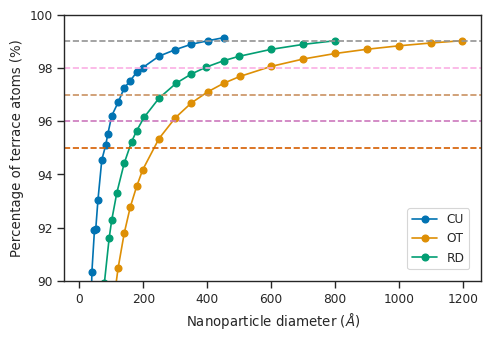

In [13]:
# Zoomed-In Convergence of the Percentage of Terrace Atoms For All Three Shapes
fig, ax = plt.subplots(figsize=(5, 3.5), sharey=True, dpi=dpi)
ax.plot(npShapeDiametersDict['CU'], percSurfAtoms['CU']['terrace'], marker='o')  #, linewidth=3, linestyle='solid',
ax.plot(npShapeDiametersDict['OT'], percSurfAtoms['OT']['terrace'], marker='o')
ax.plot(npShapeDiametersDict['RD'], percSurfAtoms['RD']['terrace'], marker='o')
ax.axhline(95, linestyle='--', color=sns.color_palette('colorblind')[3])
ax.axhline(96, linestyle='--', color=sns.color_palette('colorblind')[4])
ax.axhline(97, linestyle='--', color=sns.color_palette('colorblind')[5])
ax.axhline(98, linestyle='--', color=sns.color_palette('colorblind')[6])
ax.axhline(99, linestyle='--', color=sns.color_palette('colorblind')[7])
ax.set_xlabel(r'Nanoparticle diameter ($\AA$)')
ax.set_ylabel('Percentage of terrace atoms (%)')
ax.set_ylim(bottom=90, top=100)
fig.legend(['CU', 'OT', 'RD'], loc='lower right', bbox_to_anchor=(0.96, 0.2), ncol=1)
plt.tight_layout()
plt.savefig('figures/surfTerracePerc.png', bbox_inches='tight')

In [14]:
print('Percentage of terrace atoms for all shapes:')
for shape in ('CU', 'OT', 'RD'):
    print(f"\n{shape}")
    for (i, terracePerc) in enumerate(percSurfAtoms[shape]['terrace']): 
        if terracePerc > 95:
            print(f"{npShapeDiametersDict[shape][i]} Angstrom: {terracePerc:.2f} %")

Percentage of terrace atoms for all shapes:

CU
82 Angstrom: 95.09 %
89 Angstrom: 95.53 %
101 Angstrom: 96.20 %
121 Angstrom: 96.71 %
140 Angstrom: 97.25 %
159 Angstrom: 97.52 %
179 Angstrom: 97.84 %
198 Angstrom: 98.01 %
249 Angstrom: 98.45 %
300 Angstrom: 98.69 %
350 Angstrom: 98.89 %
401 Angstrom: 99.02 %
451 Angstrom: 99.14 %

OT
249 Angstrom: 95.35 %
300 Angstrom: 96.13 %
350 Angstrom: 96.69 %
401 Angstrom: 97.10 %
451 Angstrom: 97.43 %
502 Angstrom: 97.68 %
599 Angstrom: 98.06 %
700 Angstrom: 98.34 %
801 Angstrom: 98.55 %
899 Angstrom: 98.70 %
1000 Angstrom: 98.83 %
1101 Angstrom: 98.94 %
1198 Angstrom: 99.03 %

RD
163 Angstrom: 95.23 %
179 Angstrom: 95.64 %
202 Angstrom: 96.14 %
249 Angstrom: 96.87 %
303 Angstrom: 97.43 %
350 Angstrom: 97.77 %
397 Angstrom: 98.04 %
451 Angstrom: 98.27 %
498 Angstrom: 98.44 %
599 Angstrom: 98.70 %
700 Angstrom: 98.89 %
801 Angstrom: 99.03 %


The percentages of terrace atoms for `CU`, `OT`, and `RD` are:
- above $95\%$ when the diameters are $8.2$, $24.9$, and $16.3$ nm, respectively.
- above $96\%$ when the diameters are $10.1$, $30.0$, and $20.2$ nm, respectively.
- above $97\%$ when the diameters are $14.0$, $40.1$, and $30.3$ nm, respectively.
- above $98\%$ when the diameters are $19.8$, $59.9$, and $39.7$ nm, respectively. 
- above $99\%$ when the diameters are $45.1$, $119.8$, and $80.1$ nm, respectively. 

### Computing Box-Counting Dimensions for the Large Nanoparticles

Due to the large size of the nanoparticles, the alpha shape algorithm takes a long time to identify the surface atoms. A simpler criterion based on the number of neighbours `numNeigh` is used instead. The parameter values involved are recorded below:
- `findSurfAlg`: `numNeigh`
- `radType`: `atomic`
- `radMult`: $1.2$ for `CU`, $1.1$ for `RD`, either works for `OT`
- `bulkCN`: $14$ for `CU`, $12$ for `RD`, either works for `OT`

In [15]:
facetsDFlist = []
for terracePerc in range(95, 99):
    for surfRep in ('EX', 'VX', 'VXF'):
        with open(f"data/facets{surfRep}{terracePerc}.pickle", 'rb') as f:
            df = pickle.load(f)
        df.dropna(axis=1, inplace=True)
        df.columns = ['DBox', 'lowCI', 'upCI', 'R2', 'minLen', 'maxLen', 'NPname']
        df['surfRep'] = surfRep
        df['terracePerc'] = terracePerc
        df['shape'] = df.apply(lambda f: f['NPname'][-5:-3], axis=1)
        df['rangeLen'] = df.apply(lambda f: f['maxLen'] - f['minLen'], axis=1)
        facetsDFlist.append(df)
facetsDF = pd.concat(facetsDFlist, axis=0)
facetsEXDF = facetsDF[facetsDF['surfRep'] == 'EX']
facetsEXDF.head()

,DBox,lowCI,upCI,R2,minLen,maxLen,NPname,surfRep,terracePerc,shape,rangeLen
Pd82CU_EX,2.327020,2.101026,2.553015,0.988330,-0.530958,0.470647,Pd82CU_EX,EX,95,CU,1.001606
Pd163RD_EX,2.507057,2.327689,2.686425,0.998486,-0.531429,-0.029484,Pd163RD_EX,EX,95,RD,0.501945
Pd249OT_EX,2.309393,2.146091,2.472696,0.996231,-0.532419,0.220236,Pd249OT_EX,EX,95,OT,0.752655
Pd101CU_EX,2.334755,2.106629,2.562882,0.988189,-0.540720,0.470003,Pd101CU_EX,EX,96,CU,1.010724
Pd202RD_EX,2.231528,2.105181,2.357875,0.998339,-0.534517,0.094695,Pd202RD_EX,EX,96,RD,0.629212


The box-counting dimensions obtained from the exact surface representation, ${D_B}_E$ are deemed more useful for this investigation due to the following reasons:
- ${D_B}_E$ has allowed the ordered and disordered metallic nanoparticle surfaces to be distinguished better than ${D_B}_V$ in previous works.
- The limitation of the 3D binary image's resolution to $1024 \times 1024 \times 1024$ voxels due to memory constraint makes the voxelised point cloud representation non-ideal when dealing with large nanoparticles, as the nanoscale details would not be captured well.

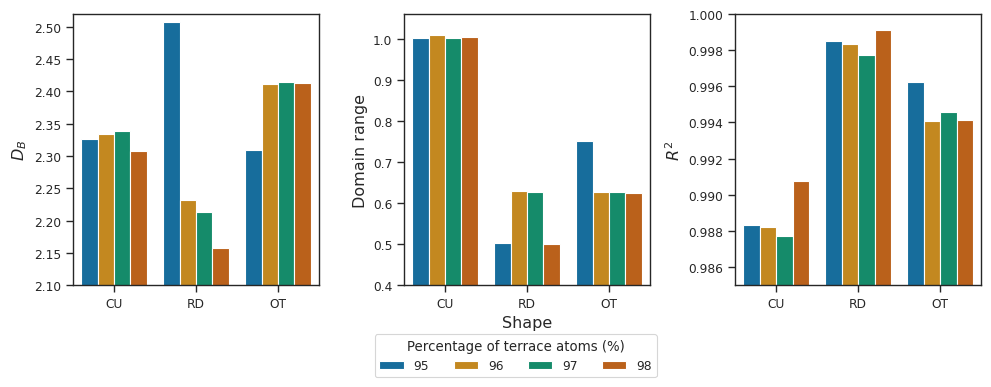

In [16]:
# Differences in Box-Counting Dimension, Domain Range, and Coefficient of Determination as a Function of Shape (Facet Type)
fig, axes = plt.subplots(1, 3, figsize=(10, 3.5), sharex=True, dpi=dpi)
g = sns.barplot(data=facetsEXDF, x='shape', y='DBox', hue='terracePerc', ax=axes[0])
axes[0].set_ylim(bottom=2.1, top=2.52)
axes[0].set_xlabel('', fontsize='large')
axes[0].set_ylabel(r'$D_B$', fontsize='large')
axes[0].legend([],[], frameon=False)
g = sns.barplot(data=facetsEXDF, x='shape', y='rangeLen', hue='terracePerc', ax=axes[1])
axes[1].set_ylim(bottom=0.4)
axes[1].set_xlabel('Shape', fontsize='large')
axes[1].set_ylabel(r'Domain range', fontsize='large')
axes[1].legend([],[], frameon=False)
g = sns.barplot(data=facetsEXDF, x='shape', y='R2', hue='terracePerc', ax=axes[2])
axes[2].set_ylim(bottom=0.985, top=1.00)
axes[2].set_xlabel('')
axes[2].set_ylabel(r'$R^2$', fontsize='large')
axes[2].legend([],[], frameon=False)
legendHandle, _ = axes[1].get_legend_handles_labels()
fig.legend(handles=legendHandle, title='Percentage of terrace atoms (%)', loc='lower center', bbox_to_anchor=(0.52, -0.11), ncol=4)
plt.tight_layout()
plt.savefig('figures/facetsDBoxRangeR2.png', bbox_inches='tight')

The trend of ${D_B}_E$ values obtained from the palladium nanoparticles with around 95% surface atoms being terrace atoms differs from the other nanoparticle sizes. Greater weight should be placed on the nanoparticles with a larger percentage of surface atoms being terrace because the influence of corner and edge atoms are minimised in these cases. 

The trends observed from the larger palladium nanoparticles (i.e. nanoparticles with 96%, 97%, 98% surface atoms being terrace atoms) indicate that the ${D_B}_E$ values follow the trend of `RD` < `CU` < `OT`, which is equivalent to `{110}` < `{100}` < `{111}`. This implies that the `{111}` facets result in rougher surfaces compared to the `{100}` facets, which is then followed by the `{110}` facets.

The results agree with the trends observed by Mendoza-Pérez and Guisbiers, whose publication on [Bimetallic Pt–Pd nano-catalyst: size, shape and composition matter](https://doi.org/10.1088/1361-6528/ab1759) indicated that `TH` (which is also covered by `{111}` facets) and `CU` are more catalytically active than `RD`, in accordance with the previous theoretical and experimental findings.

<a id='mnps'></a>
## Comparison between Monometallic Nanoparticles of Different Elements under Similar Conditions

Here we analyse the $D_B$ values of the conformations of some monometallic nanoparticles consisted of different elements under similar environmental conditions (at temperature of $323$ K, or $50\degree C$).

### Data Set

The data used here are obtained from collections of atomic coordinates of simulated palladium, copper, and gold nanoparticles generated for deposition studies to studying the impact of polydispersivity on the properties of the nanoparticles. The data sets are hosted at CSIRO Data Access Portal: [palladium](https://data.csiro.au/collection/csiro:40618), [copper](https://data.csiro.au/collection/csiro:42598), and [gold](https://data.csiro.au/collection/csiro:40669). The platinum nanoparticle data set is excluded as the nanoparticles are simulated at a different temperature ($673$ K, or $400\degree C$).

In [17]:
# Load all data
cols = ['element', 'shape', 'size', 'DBox', 'surfRep', 'rangeLen', 'minLen', 'maxLen', 'R2']  # 'lowCIEX', 'upCIEX'

MNPsEXDF = readPickle('data/MNPsEX.pickle')
MNPsEXDF['MNPname'] = MNPsEXDF.apply(lambda f: f['NPname'].split('xyz')[0], axis=1)
MNPsEXDF['element'] = MNPsEXDF.apply(lambda f: f['MNPname'][:2], axis=1)
MNPsEXDF['shape'] = MNPsEXDF.apply(lambda f: f['MNPname'][2:4], axis=1)
MNPsEXDF['size'] = MNPsEXDF.apply(lambda f: f['MNPname'][-1], axis=1)
MNPsEXDF['surfRep'] = 'EX'
MNPsEXDF.reset_index(inplace=True)
MNPsEXDF.rename(
    columns={'DBoxEX': 'DBox', 'R2EX': 'R2', 'minLenEX': 'minLen', 'maxLenEX': 'maxLen', 'rangeLenEX': 'rangeLen'}, 
    inplace=True)
MNPsEXDF = MNPsEXDF[cols]

MNPsVXDF = readPickle('data/MNPsVX.pickle')
MNPsVXDF['MNPname'] = MNPsVXDF.apply(lambda f: f['NPname'].split('xyz')[0], axis=1)
MNPsVXDF['element'] = MNPsVXDF.apply(lambda f: f['MNPname'][:2], axis=1)
MNPsVXDF['shape'] = MNPsVXDF.apply(lambda f: f['MNPname'][2:4], axis=1)
MNPsVXDF['size'] = MNPsVXDF.apply(lambda f: f['MNPname'][-1], axis=1)
MNPsVXDF['surfRep'] = 'VX'
MNPsVXDF.reset_index(inplace=True)
MNPsVXDF.rename(
    columns={'DBoxVX': 'DBox', 'R2VX': 'R2', 'minLenVX': 'minLen', 'maxLenVX': 'maxLen', 'rangeLenVX': 'rangeLen'}, 
    inplace=True)
MNPsVXDF = MNPsVXDF[cols]

MNPsVXfullDF = readPickle('pickleFiles/MNPsVXfull.pickle')
MNPsVXfullDF['MNPname'] = MNPsVXfullDF.apply(lambda f: f['NPname'].split('xyz')[0], axis=1)
MNPsVXfullDF['element'] = MNPsVXfullDF.apply(lambda f: f['MNPname'][:2], axis=1)
MNPsVXfullDF['shape'] = MNPsVXfullDF.apply(lambda f: f['MNPname'][2:4], axis=1)
MNPsVXfullDF['size'] = MNPsVXfullDF.apply(lambda f: f['MNPname'][-1], axis=1)
MNPsVXfullDF['surfRep'] = 'VXF'
MNPsVXfullDF.reset_index(inplace=True)
MNPsVXfullDF.rename(
    columns={'DBoxVX': 'DBox', 'R2VX': 'R2', 'minLenVX': 'minLen', 'maxLenVX': 'maxLen', 'rangeLenVX': 'rangeLen'}, 
    inplace=True)
MNPsVXfullDF = MNPsVXfullDF[cols]

MNPsDF = pd.concat([MNPsEXDF, MNPsVXDF, MNPsVXfullDF], axis=0)
MNPsDF = MNPsDF[MNPsDF['element'] != 'Pt']  # Exclude Pt nanoparticles for aforementioned reason
MNPsDF.tail(3)

,element,shape,size,DBox,surfRep,rangeLen,minLen,maxLen,R2
51,Pd,TH,2,1.966386,VXF,2.40824,-2.70927,-0.30103,0.987909
52,Pd,TH,3,1.991885,VXF,2.40824,-2.70927,-0.30103,0.991013
53,Pd,TO,1,1.922965,VXF,2.40824,-2.70927,-0.30103,0.980914


### Comparisons Across Surface Representations

Here we look at the aggregated plots of computed results ($D_B$ values, domain range, coefficient of determination $R^2$) comparing different surface representations, with other factors being controlled.

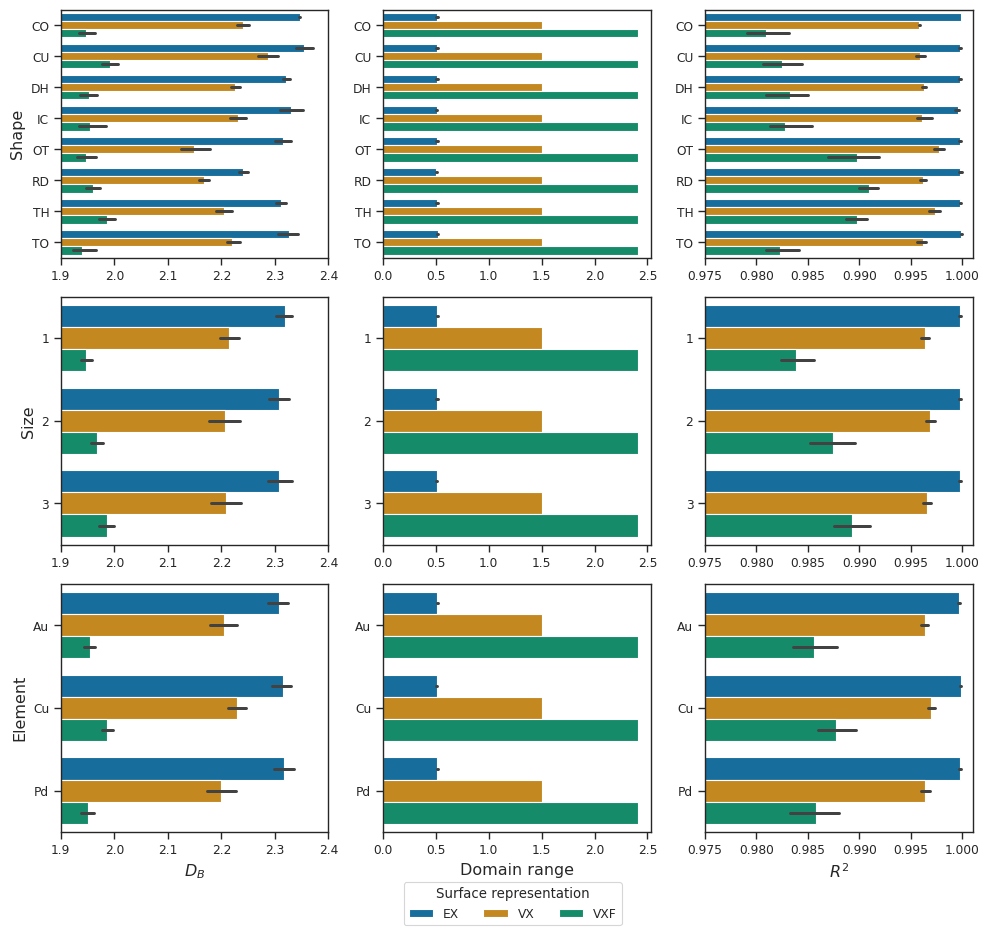

In [18]:
# Comparisons of the Box-Counting Results of Monometallic Nanoparticles Across Different Surface Representations
fig, axes = plt.subplots(3, 3, figsize=(10, 9), dpi=dpi)
g = sns.barplot(data=MNPsDF, x='DBox', y='shape', hue='surfRep', ax=axes[0, 0])
axes[0, 0].set_xlim(left=1.9, right=2.4)
axes[0, 0].set_xlabel('')
axes[0, 0].set_ylabel('Shape', fontsize='large')
axes[0, 0].legend([],[], frameon=False)
g = sns.barplot(data=MNPsDF, x='rangeLen', y='shape', hue='surfRep', ax=axes[0, 1])
axes[0, 1].set_xlabel('')
axes[0, 1].set_ylabel('')
axes[0, 1].legend([],[], frameon=False)
g = sns.barplot(data=MNPsDF, x='R2', y='shape', hue='surfRep', ax=axes[0, 2])
axes[0, 2].set_xlim(left=0.975, right=1.001)
axes[0, 2].set_xlabel('')
axes[0, 2].set_ylabel('')
axes[0, 2].legend([],[], frameon=False)
g = sns.barplot(data=MNPsDF, x='DBox', y='size', hue='surfRep', ax=axes[1, 0])
axes[1, 0].set_xlim(left=1.9, right=2.4)
axes[1, 0].set_xlabel('')
axes[1, 0].set_ylabel('Size', fontsize='large')
axes[1, 0].legend([],[], frameon=False)
g = sns.barplot(data=MNPsDF, x='rangeLen', y='size', hue='surfRep', ax=axes[1, 1])
axes[1, 1].set_xlabel('')
axes[1, 1].set_ylabel('')
axes[1, 1].legend([],[], frameon=False)
g = sns.barplot(data=MNPsDF, x='R2', y='size', hue='surfRep', ax=axes[1, 2])
axes[1, 2].set_xlim(left=0.975, right=1.001)
axes[1, 2].set_xlabel('')
axes[1, 2].set_ylabel('')
axes[1, 2].legend([],[], frameon=False)
g = sns.barplot(data=MNPsDF, x='DBox', y='element', hue='surfRep', ax=axes[2, 0])
axes[2, 0].set_xlim(left=1.9, right=2.4)
axes[2, 0].set_xlabel(r'$D_B$', fontsize='large')
axes[2, 0].set_ylabel('Element', fontsize='large')
axes[2, 0].legend([],[], frameon=False)
g = sns.barplot(data=MNPsDF, x='rangeLen', y='element', hue='surfRep', ax=axes[2, 1])
axes[2, 1].set_xlabel(r'Domain range', fontsize='large')
axes[2, 1].set_ylabel('')
axes[2, 1].legend([],[], frameon=False)
g = sns.barplot(data=MNPsDF, x='R2', y='element', hue='surfRep', ax=axes[2, 2])
axes[2, 2].set_xlim(left=0.975, right=1.001)
axes[2, 2].set_xlabel(r'$R^2$', fontsize='large')
axes[2, 2].set_ylabel('')
axes[2, 2].legend([],[], frameon=False)

legendHandle, _ = axes[0, 0].get_legend_handles_labels()
fig.legend(handles=legendHandle, title='Surface representation', loc='lower center', bbox_to_anchor=(0.517, -0.04), ncol=3)
plt.tight_layout()
# g.savefig('figures/MNPsSurfaceRepAgg.png')

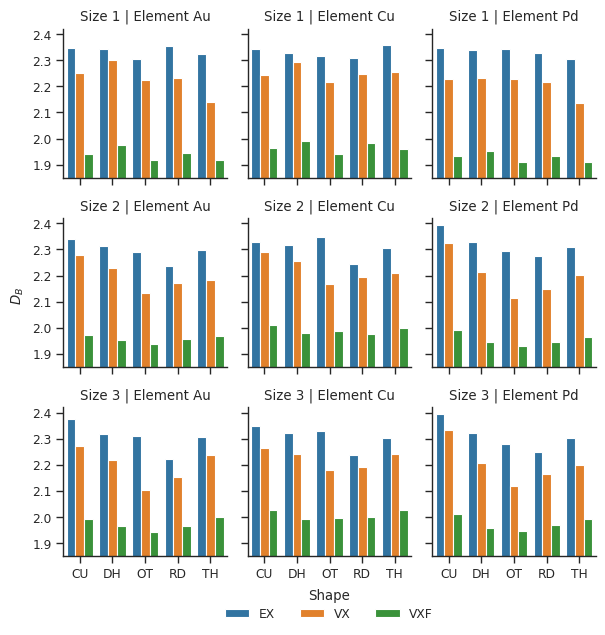

In [19]:
# Comparisons of the Box-Counting Dimensions of Monometallic Nanoparticles Across Different Surface Representations
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
        
    g = sns.FacetGrid(MNPsDF, row='size', col='element', sharex=True, sharey=True, height=2, aspect=1)
    g.map_dataframe(sns.barplot, x='shape', y='DBox', hue='surfRep', palette='tab10', errwidth=1.2, capsize=0.1)
    g.set(ylim=(1.85, 2.42))
    g.set_axis_labels('', '')
    g.set_titles(row_template='Size {row_name}', col_template='Element {col_name}')
    g.figure.subplots_adjust(wspace=0, hspace=0)
    g.figure.text(0.355, 0.0, 'Shape', va='center')
    g.figure.text(-0.01, 0.5, r'${D_B}$', va='center', rotation='vertical')
    g.add_legend(title='', loc='lower center', bbox_to_anchor=(0.38, -0.06), ncol=3)
    g.tight_layout()
    # g.savefig('figures/MNPsSurfaceRepDBox.png')

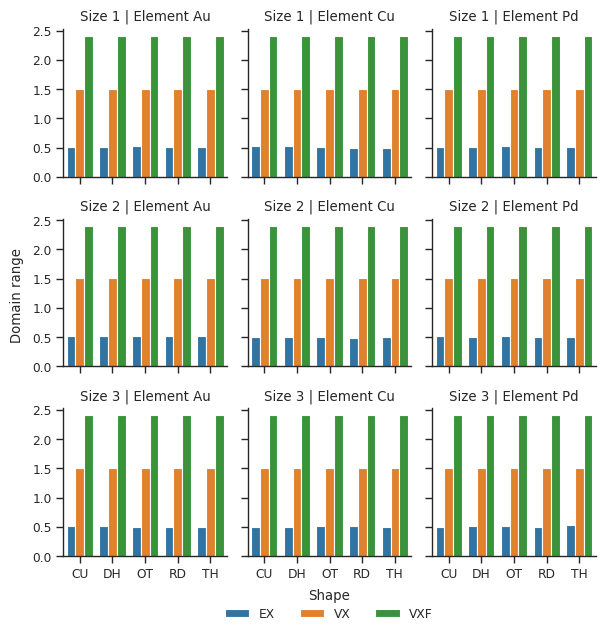

In [20]:
# Comparisons of the Domain Ranges of Monometallic Nanoparticles Across Different Surface Representations
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
        
    g = sns.FacetGrid(MNPsDF, row='size', col='element', sharex=True, sharey=True, height=2, aspect=1)
    g.map_dataframe(sns.barplot, x='shape', y='rangeLen', hue='surfRep', palette='tab10', errwidth=1.2, capsize=0.1)
    g.set_axis_labels('', '')
    g.set_titles(row_template='Size {row_name}', col_template='Element {col_name}')
    g.figure.subplots_adjust(wspace=0, hspace=0)
    g.figure.text(0.355, 0.0, 'Shape', va='center')
    g.figure.text(-0.01, 0.5, 'Domain range', va='center', rotation='vertical')
    g.add_legend(title='', loc='lower center', bbox_to_anchor=(0.38, -0.06), ncol=3)
    g.tight_layout()
    # g.savefig('figures/MNPsSurfaceRepDomain.png')

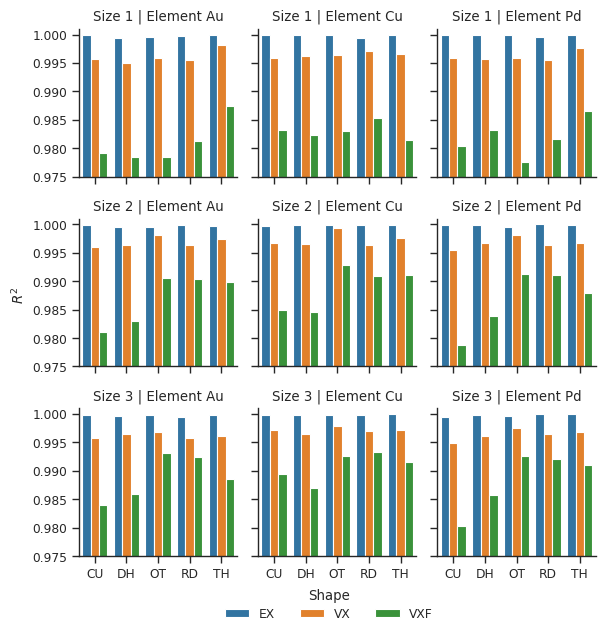

In [21]:
# Comparisons of the Coefficients of Determination of Monometallic Nanoparticles Across Different Surface Representations
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
        
    g = sns.FacetGrid(MNPsDF, row='size', col='element', sharex=True, sharey=True, height=2, aspect=1)
    g.map_dataframe(sns.barplot, x='shape', y='R2', hue='surfRep', palette='tab10', errwidth=1.2, capsize=0.1)
    g.set(ylim=(0.975, 1.001))
    g.set_axis_labels('', '')
    g.set_titles(row_template='Size {row_name}', col_template='Element {col_name}')
    g.figure.subplots_adjust(wspace=0, hspace=0)
    g.figure.text(0.355, 0.0, 'Shape', va='center')
    g.figure.text(-0.01, 0.5, r'$R^2$', va='center', rotation='vertical')
    g.add_legend(title='', loc='lower center', bbox_to_anchor=(0.38, -0.06), ncol=3)
    g.tight_layout()
    # g.savefig('figures/MNPsSurfaceRepR2.png')

In [22]:
# fig, axes = plt.subplots(1, 3, figsize=(10, 3.5), sharey=True, dpi=dpi)
# g = sns.barplot(data=MNPsDF, x='DBox', y='shape', hue='surfRep', ax=axes[0])
# axes[0].set_xlim(left=1.9, right=2.4)
# axes[0].set_xlabel(r'$D_B$', fontsize='large')
# axes[0].set_ylabel('Shape', fontsize='large')
# axes[0].legend([],[], frameon=False)
# g = sns.barplot(data=MNPsDF, x='rangeLen', y='shape', hue='surfRep', ax=axes[1])
# axes[1].set_xlabel(r'Domain range', fontsize='large')
# axes[1].set_ylabel('')
# axes[1].legend([],[], frameon=False)
# g = sns.barplot(data=MNPsDF, x='R2', y='shape', hue='surfRep', ax=axes[2])
# axes[2].set_xlim(left=0.975, right=1.001)
# axes[2].set_xlabel(r'$R^2$', fontsize='large')
# axes[2].set_ylabel('')
# axes[2].legend([],[], frameon=False)
# legendHandle, _ = axes[1].get_legend_handles_labels()
# fig.legend(handles=legendHandle, title='Surface representation', loc='lower center', bbox_to_anchor=(0.517, -0.11), ncol=3)
# plt.tight_layout()
# # g.savefig('figures/MNPsSurfaceRepAggShape.png')

In [23]:
# fig, axes = plt.subplots(1, 3, figsize=(10, 3.5), sharey=True, dpi=dpi)
# g = sns.barplot(data=MNPsDF, x='DBox', y='size', hue='surfRep', ax=axes[0])
# axes[0].set_xlim(left=1.9, right=2.4)
# axes[0].set_xlabel(r'$D_B$', fontsize='large')
# axes[0].set_ylabel('Size', fontsize='large')
# axes[0].legend([],[], frameon=False)
# g = sns.barplot(data=MNPsDF, x='rangeLen', y='size', hue='surfRep', ax=axes[1])
# axes[1].set_xlabel(r'Domain range', fontsize='large')
# axes[1].set_ylabel('')
# axes[1].legend([],[], frameon=False)
# g = sns.barplot(data=MNPsDF, x='R2', y='size', hue='surfRep', ax=axes[2])
# axes[2].set_xlim(left=0.975, right=1.001)
# axes[2].set_xlabel(r'$R^2$', fontsize='large')
# axes[2].set_ylabel('')
# axes[2].legend([],[], frameon=False)
# legendHandle, _ = axes[1].get_legend_handles_labels()
# fig.legend(handles=legendHandle, title='Surface representation', loc='lower center', bbox_to_anchor=(0.515, -0.11), ncol=3)
# plt.tight_layout()
# # g.savefig('figures/MNPsSurfaceRepAggSize.png')

In [24]:
# fig, axes = plt.subplots(1, 3, figsize=(10, 3.5), sharey=True, dpi=dpi)
# g = sns.barplot(data=MNPsDF, x='DBox', y='element', hue='surfRep', ax=axes[0])
# axes[0].set_xlim(left=1.9, right=2.4)
# axes[0].set_xlabel(r'$D_B$', fontsize='large')
# axes[0].set_ylabel('Element', fontsize='large')
# axes[0].legend([],[], frameon=False)
# g = sns.barplot(data=MNPsDF, x='rangeLen', y='element', hue='surfRep', ax=axes[1])
# axes[1].set_xlabel(r'Domain range', fontsize='large')
# axes[1].set_ylabel('')
# axes[1].legend([],[], frameon=False)
# g = sns.barplot(data=MNPsDF, x='R2', y='element', hue='surfRep', ax=axes[2])
# axes[2].set_xlim(left=0.975, right=1.001)
# axes[2].set_xlabel(r'$R^2$', fontsize='large')
# axes[2].set_ylabel('')
# axes[2].legend([],[], frameon=False)
# legendHandle, _ = axes[1].get_legend_handles_labels()
# fig.legend(handles=legendHandle, title='Surface representation', loc='lower center', bbox_to_anchor=(0.515, -0.11), ncol=3)
# plt.tight_layout()
# # g.savefig('figures/MNPsSurfaceRepAggElement.png')

It is clear from the figures above that the ${D_B}$ and $R^2$ values for exact surface representation are consistently higher than the voxelised point cloud representation of surface, which are in turn higher than the values obtained from linear regression without point removal, regardless of the nanoparticle shapes, sizes, and elements. On the other hand, the domain range follows the exact opposite trend.

This indicates that the box-counting dimensions computed from the exact surface representations are capturing a more local (narrower domain range) power law relationship (highly linear, and much steeper) compared to the voxelised point cloud representation.

### Comparisons Across Shapes
Here we look at the aggregated plots of computed results ($D_B$ values, domain range, coefficient of determination $R^2$) comparing different shapes, with different other factors being controlled.

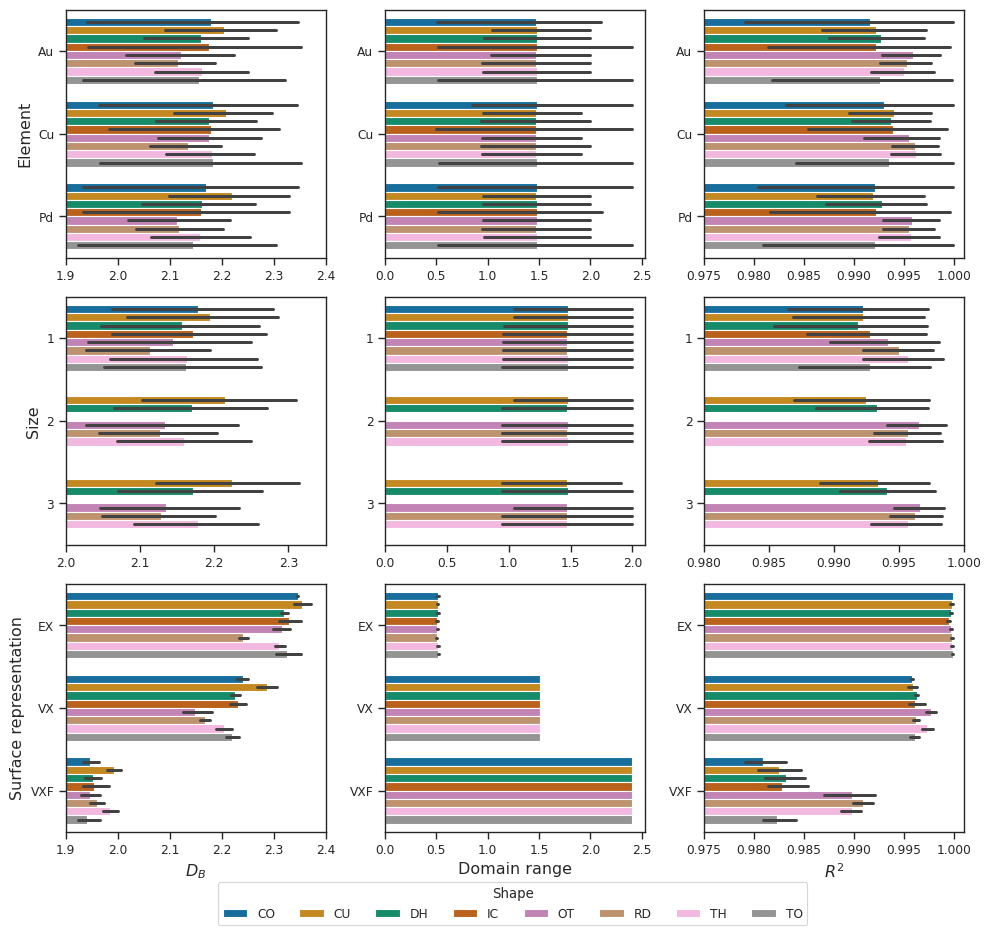

In [25]:
# Comparisons of the Box-Counting Results of Monometallic Nanoparticles Across Different Shapes
fig, axes = plt.subplots(3, 3, figsize=(10, 9), dpi=dpi)
g = sns.barplot(data=MNPsDF, x='DBox', y='element', hue='shape', ax=axes[0, 0])
axes[0, 0].set_xlim(left=1.9, right=2.4)
axes[0, 0].set_xlabel('')
axes[0, 0].set_ylabel('Element', fontsize='large')
axes[0, 0].legend([],[], frameon=False)
g = sns.barplot(data=MNPsDF, x='rangeLen', y='element', hue='shape', ax=axes[0, 1])
axes[0, 1].set_xlabel('')
axes[0, 1].set_ylabel('')
axes[0, 1].legend([],[], frameon=False)
g = sns.barplot(data=MNPsDF, x='R2', y='element', hue='shape', ax=axes[0, 2])
axes[0, 2].set_xlim(left=0.975, right=1.001)
axes[0, 2].set_xlabel('')
axes[0, 2].set_ylabel('')
axes[0, 2].legend([],[], frameon=False)
g = sns.barplot(data=MNPsDF, x='DBox', y='size', hue='shape', ax=axes[1, 0])
axes[1, 0].set_xlim(left=2.0, right=2.35)
axes[1, 0].set_xlabel('')
axes[1, 0].set_ylabel('Size', fontsize='large')
axes[1, 0].legend([],[], frameon=False)
g = sns.barplot(data=MNPsDF, x='rangeLen', y='size', hue='shape', ax=axes[1, 1])
axes[1, 1].set_xlabel('')
axes[1, 1].set_ylabel('')
axes[1, 1].legend([],[], frameon=False)
g = sns.barplot(data=MNPsDF, x='R2', y='size', hue='shape', ax=axes[1, 2])
axes[1, 2].set_xlim(left=0.98, right=1.00)
axes[1, 2].set_xlabel('')
axes[1, 2].set_ylabel('')
axes[1, 2].legend([],[], frameon=False)
g = sns.barplot(data=MNPsDF, x='DBox', y='surfRep', hue='shape', ax=axes[2, 0])
axes[2, 0].set_xlim(left=1.9, right=2.4)
axes[2, 0].set_xlabel(r'$D_B$', fontsize='large')
axes[2, 0].set_ylabel('Surface representation', fontsize='large')
axes[2, 0].legend([],[], frameon=False)
g = sns.barplot(data=MNPsDF, x='rangeLen', y='surfRep', hue='shape', ax=axes[2, 1])
axes[2, 1].set_xlabel(r'Domain range', fontsize='large')
axes[2, 1].set_ylabel('')
axes[2, 1].legend([],[], frameon=False)
g = sns.barplot(data=MNPsDF, x='R2', y='surfRep', hue='shape', ax=axes[2, 2])
axes[2, 2].set_xlim(left=0.975, right=1.001)
axes[2, 2].set_xlabel(r'$R^2$', fontsize='large')
axes[2, 2].set_ylabel('')
axes[2, 2].legend([],[], frameon=False)

legendHandle, _ = axes[0, 0].get_legend_handles_labels()
fig.legend(handles=legendHandle, title='Shape', loc='lower center', bbox_to_anchor=(0.517, -0.04), ncol=8)
plt.tight_layout()
# g.savefig('figures/MNPsShapeAgg.png', bbox_inches='tight')

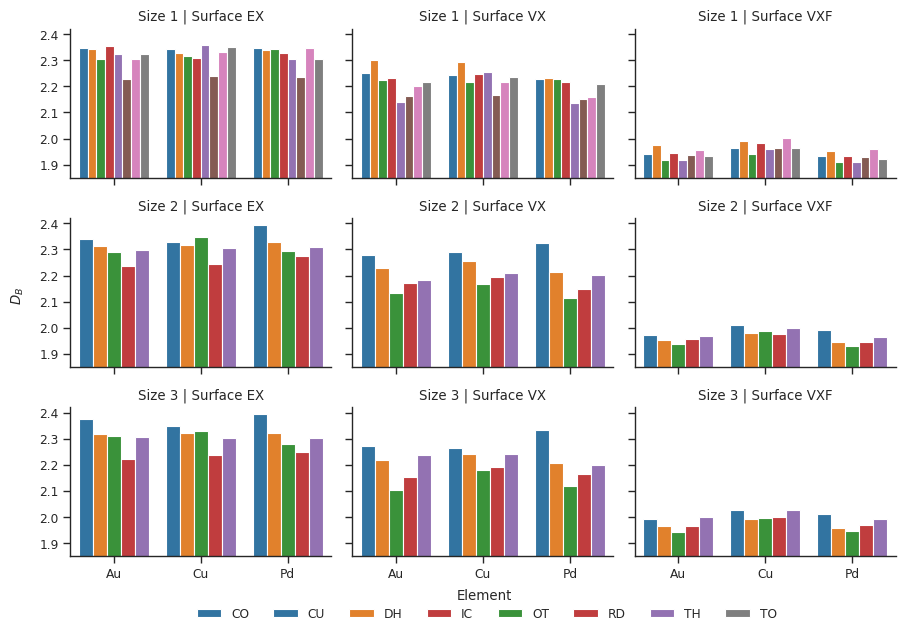

In [26]:
# Comparisons of the Box-Counting Dimensions of Monometallic Nanoparticles Across Different Shapes
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
        
    g = sns.FacetGrid(MNPsDF, row='size', col='surfRep', sharex=True, sharey=True, height=2, aspect=1.5)
    g.map_dataframe(sns.barplot, x='element', y='DBox', hue='shape', palette='tab10', errwidth=1.2, capsize=0.1)
    g.set(ylim=(1.85, 2.42))
    g.set_axis_labels('', '')
    g.set_titles(row_template='Size {row_name}', col_template='Surface {col_name}')
    g.figure.subplots_adjust(wspace=0, hspace=0)
    g.figure.text(0.29, 0.0, 'Element', va='center')
    g.figure.text(-0.01, 0.5, r'$D_B$', va='center', rotation='vertical')
    g.add_legend(title='', loc='lower center', bbox_to_anchor=(0.31, -0.06), ncol=8)
    g.tight_layout()
    # g.savefig('figures/MNPsShapeDBox.png')

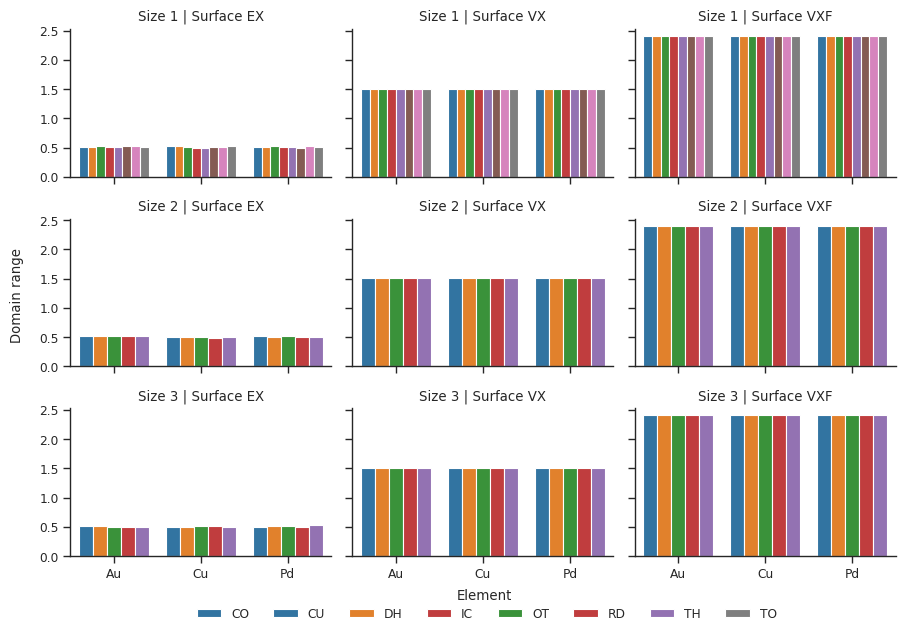

In [27]:
# Comparisons of the Domain Ranges of Monometallic Nanoparticles Across Different Shapes
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
        
    g = sns.FacetGrid(MNPsDF, row='size', col='surfRep', sharex=True, sharey=True, height=2, aspect=1.5)
    g.map_dataframe(sns.barplot, x='element', y='rangeLen', hue='shape', palette='tab10', errwidth=1.2, capsize=0.1)
    g.set_axis_labels('', '')
    g.set_titles(row_template='Size {row_name}', col_template='Surface {col_name}')
    g.figure.subplots_adjust(wspace=0, hspace=0)
    g.figure.text(0.29, 0.0, 'Element', va='center')
    g.figure.text(-0.01, 0.5, 'Domain range', va='center', rotation='vertical')
    g.add_legend(title='', loc='lower center', bbox_to_anchor=(0.31, -0.06), ncol=8)
    g.tight_layout()
    # g.savefig('figures/MNPsShapeDomain.png')

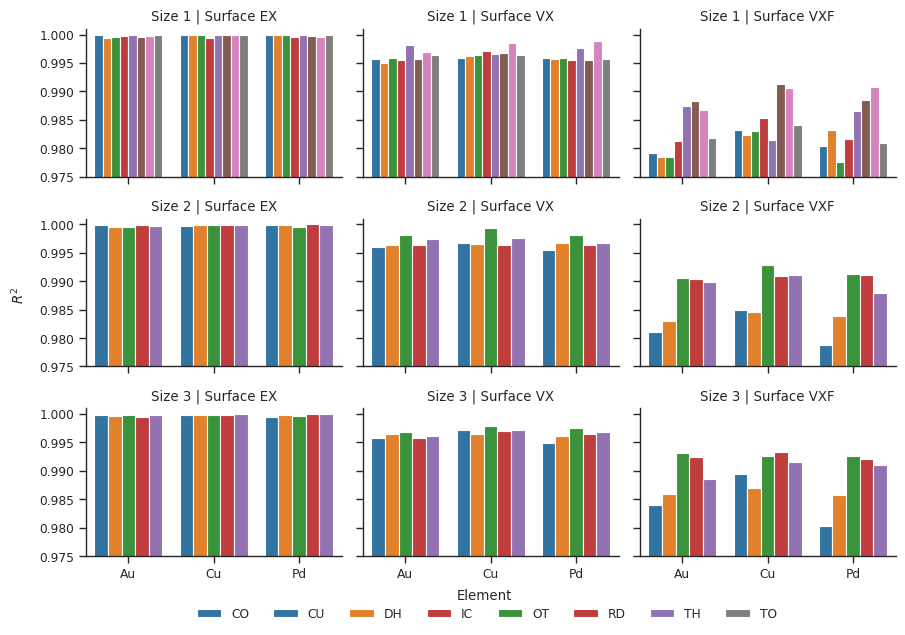

In [28]:
# Comparisons of the Coefficients of Detemrination of Monometallic Nanoparticles Across Different Shapes
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
        
    g = sns.FacetGrid(MNPsDF, row='size', col='surfRep', sharex=True, sharey=True, height=2, aspect=1.5)
    g.map_dataframe(sns.barplot, x='element', y='R2', hue='shape', palette='tab10', errwidth=1.2, capsize=0.1)
    g.set(ylim=(0.975, 1.001))
    g.set_axis_labels('', '')
    g.set_titles(row_template='Size {row_name}', col_template='Surface {col_name}')
    g.figure.subplots_adjust(wspace=0, hspace=0)
    g.figure.text(0.29, 0.0, 'Element', va='center')
    g.figure.text(-0.01, 0.5, r'$R^2$', va='center', rotation='vertical')
    g.add_legend(title='', loc='lower center', bbox_to_anchor=(0.31, -0.06), ncol=8)
    g.tight_layout()
    # g.savefig('figures/MNPsShapeR2.png')

In [29]:
# fig, axes = plt.subplots(1, 3, figsize=(10, 3.5), sharey=True, dpi=dpi)
# g = sns.barplot(data=MNPsDF, x='DBox', y='element', hue='shape', ax=axes[0])
# axes[0].set_xlim(left=1.9, right=2.4)
# axes[0].set_xlabel(r'$D_B$', fontsize='large')
# axes[0].set_ylabel('Shape', fontsize='large')
# axes[0].legend([],[], frameon=False)
# g = sns.barplot(data=MNPsDF, x='rangeLen', y='element', hue='shape', ax=axes[1])
# axes[1].set_xlabel(r'Domain range', fontsize='large')
# axes[1].set_ylabel('')
# axes[1].legend([],[], frameon=False)
# g = sns.barplot(data=MNPsDF, x='R2', y='element', hue='shape', ax=axes[2])
# axes[2].set_xlim(left=0.975, right=1.001)
# axes[2].set_xlabel(r'$R^2$', fontsize='large')
# axes[2].set_ylabel('')
# axes[2].legend([],[], frameon=False)
# legendHandle, _ = axes[1].get_legend_handles_labels()
# fig.legend(handles=legendHandle, title='Shape', loc='lower center', bbox_to_anchor=(0.523, -0.11), ncol=8)
# plt.tight_layout()
# # g.savefig('figures/MNPsShapeAggElement.png')

In [30]:
# fig, axes = plt.subplots(1, 3, figsize=(10, 3.5), sharey=True, dpi=dpi)
# g = sns.barplot(data=MNPsDF, x='DBox', y='size', hue='shape', ax=axes[0])
# axes[0].set_xlim(left=2.0, right=2.35)
# axes[0].set_xlabel(r'$D_B$', fontsize='large')
# axes[0].set_ylabel('Size', fontsize='large')
# axes[0].legend([],[], frameon=False)
# g = sns.barplot(data=MNPsDF, x='rangeLen', y='size', hue='shape', ax=axes[1])
# axes[1].set_xlabel(r'Domain range', fontsize='large')
# axes[1].set_ylabel('')
# axes[1].legend([],[], frameon=False)
# g = sns.barplot(data=MNPsDF, x='R2', y='size', hue='shape', ax=axes[2])
# axes[2].set_xlim(left=0.98, right=1.00)
# axes[2].set_xlabel(r'$R^2$', fontsize='large')
# axes[2].set_ylabel('')
# axes[2].legend([],[], frameon=False)
# legendHandle, _ = axes[1].get_legend_handles_labels()
# fig.legend(handles=legendHandle, title='Shape', loc='lower center', bbox_to_anchor=(0.52, -0.11), ncol=8)
# plt.tight_layout()
# g.savefig('figures/MNPsShapeAggSize.png')

In [31]:
# fig, axes = plt.subplots(1, 3, figsize=(10, 3.5), sharey=True, dpi=dpi)
# g = sns.barplot(data=MNPsDF, x='DBox', y='surfRep', hue='shape', ax=axes[0])
# axes[0].set_xlim(left=1.9, right=2.4)
# axes[0].set_xlabel(r'$D_B$', fontsize='large')
# axes[0].set_ylabel('Surface representation', fontsize='large')
# axes[0].legend([],[], frameon=False)
# g = sns.barplot(data=MNPsDF, x='rangeLen', y='surfRep', hue='shape', ax=axes[1])
# axes[1].set_xlabel(r'Domain range', fontsize='large')
# axes[1].set_ylabel('')
# axes[1].legend([],[], frameon=False)
# g = sns.barplot(data=MNPsDF, x='R2', y='surfRep', hue='shape', ax=axes[2])
# axes[2].set_xlim(left=0.975, right=1.001)
# axes[2].set_xlabel(r'$R^2$', fontsize='large')
# axes[2].set_ylabel('')
# axes[2].legend([],[], frameon=False)
# legendHandle, _ = axes[1].get_legend_handles_labels()
# fig.legend(handles=legendHandle, title='Shape', loc='lower center', bbox_to_anchor=(0.523, -0.11), ncol=8)
# plt.tight_layout()
# # g.savefig('figures/MNPsShapeAggSurfRep.png')

#### Surface Specific Plots

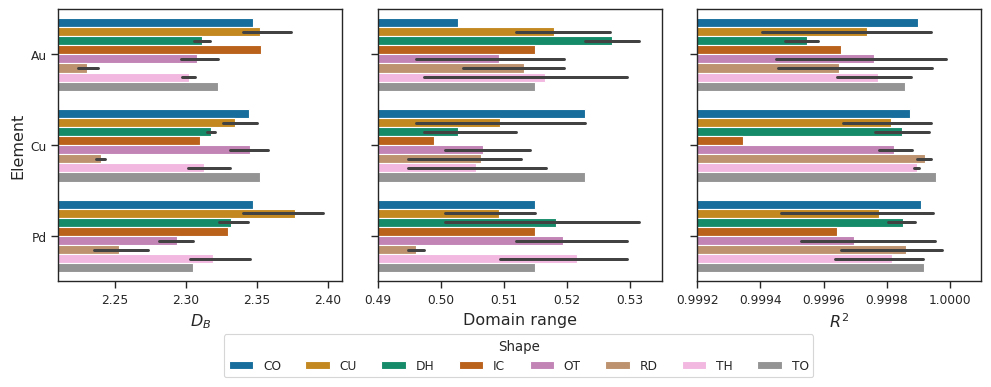

In [32]:
fig, axes = plt.subplots(1, 3, figsize=(10, 3.5), sharey=True, dpi=dpi)
g = sns.barplot(data=MNPsDF[MNPsDF['surfRep'] == 'EX'], x='DBox', y='element', hue='shape', ax=axes[0])
axes[0].set_xlim(left=2.21, right=2.41)
axes[0].set_xlabel(r'$D_B$', fontsize='large')
axes[0].set_ylabel('Element', fontsize='large')
axes[0].legend([],[], frameon=False)
g = sns.barplot(data=MNPsDF[MNPsDF['surfRep'] == 'EX'], x='rangeLen', y='element', hue='shape', ax=axes[1])
axes[1].set_xlim(left=0.49, right=0.535)
axes[1].set_xlabel(r'Domain range', fontsize='large')
axes[1].set_ylabel('')
axes[1].legend([],[], frameon=False)
g = sns.barplot(data=MNPsDF[MNPsDF['surfRep'] == 'EX'], x='R2', y='element', hue='shape', ax=axes[2])
axes[2].set_xlim(left=0.9992, right=1.0001)
axes[2].set_xlabel(r'$R^2$', fontsize='large')
axes[2].set_ylabel('')
axes[2].legend([],[], frameon=False)
legendHandle, _ = axes[1].get_legend_handles_labels()
fig.legend(handles=legendHandle, title='Shape', loc='lower center', bbox_to_anchor=(0.523, -0.11), ncol=8)
plt.tight_layout()
# g.savefig('figures/MNPsEXShapeAggElement.png')

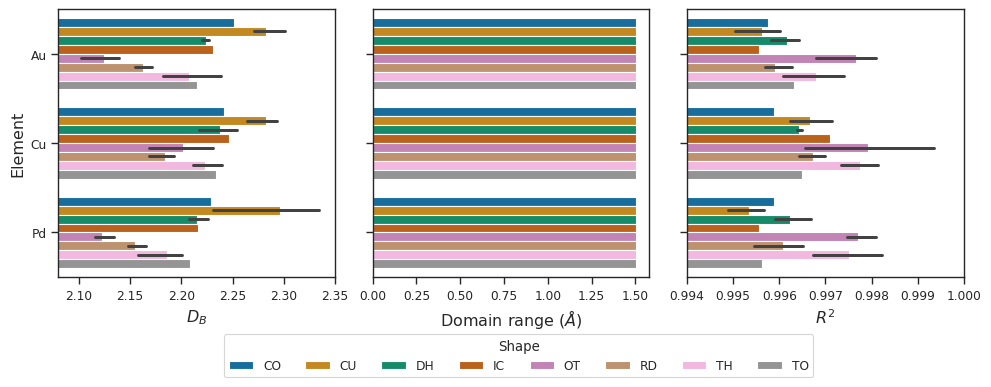

In [33]:
fig, axes = plt.subplots(1, 3, figsize=(10, 3.5), sharey=True, dpi=dpi)
g = sns.barplot(data=MNPsDF[MNPsDF['surfRep'] == 'VX'], x='DBox', y='element', hue='shape', ax=axes[0])
axes[0].set_xlim(left=2.08, right=2.35)
axes[0].set_xlabel(r'$D_B$', fontsize='large')
axes[0].set_ylabel('Element', fontsize='large')
axes[0].legend([],[], frameon=False)
g = sns.barplot(data=MNPsDF[MNPsDF['surfRep'] == 'VX'], x='rangeLen', y='element', hue='shape', ax=axes[1])
axes[1].set_xlabel(r'Domain range ($\AA$)', fontsize='large')
axes[1].set_ylabel('')
axes[1].legend([],[], frameon=False)
g = sns.barplot(data=MNPsDF[MNPsDF['surfRep'] == 'VX'], x='R2', y='element', hue='shape', ax=axes[2])
axes[2].set_xlim(left=0.994, right=1.00)
axes[2].set_xlabel(r'$R^2$', fontsize='large')
axes[2].set_ylabel('')
axes[2].legend([],[], frameon=False)
legendHandle, _ = axes[1].get_legend_handles_labels()
fig.legend(handles=legendHandle, title='Shape', loc='lower center', bbox_to_anchor=(0.523, -0.11), ncol=8)
plt.tight_layout()
# g.savefig('figures/MNPsVXShapeAggElement.png')

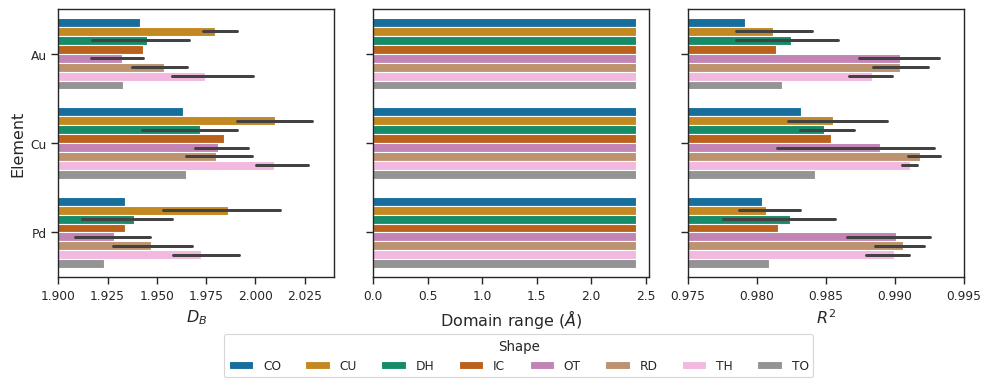

In [34]:
fig, axes = plt.subplots(1, 3, figsize=(10, 3.5), sharey=True, dpi=dpi)
g = sns.barplot(data=MNPsDF[MNPsDF['surfRep'] == 'VXF'], x='DBox', y='element', hue='shape', ax=axes[0])
axes[0].set_xlim(left=1.9, right=2.04)
axes[0].set_xlabel(r'$D_B$', fontsize='large')
axes[0].set_ylabel('Element', fontsize='large')
axes[0].legend([],[], frameon=False)
g = sns.barplot(data=MNPsDF[MNPsDF['surfRep'] == 'VXF'], x='rangeLen', y='element', hue='shape', ax=axes[1])
axes[1].set_xlabel(r'Domain range ($\AA$)', fontsize='large')
axes[1].set_ylabel('')
axes[1].legend([],[], frameon=False)
g = sns.barplot(data=MNPsDF[MNPsDF['surfRep'] == 'VXF'], x='R2', y='element', hue='shape', ax=axes[2])
axes[2].set_xlim(left=0.975, right=0.995)
axes[2].set_xlabel(r'$R^2$', fontsize='large')
axes[2].set_ylabel('')
axes[2].legend([],[], frameon=False)
legendHandle, _ = axes[1].get_legend_handles_labels()
fig.legend(handles=legendHandle, title='Shape', loc='lower center', bbox_to_anchor=(0.523, -0.11), ncol=8)
plt.tight_layout()
# g.savefig('figures/MNPsVXFShapeAggElement.png')

### Comparisons Across Sizes
Here we look at the aggregated plots of computed results ($D_B$ values, domain range, coefficient of determination $R^2$) comparing different sizes, with other factors being controlled.

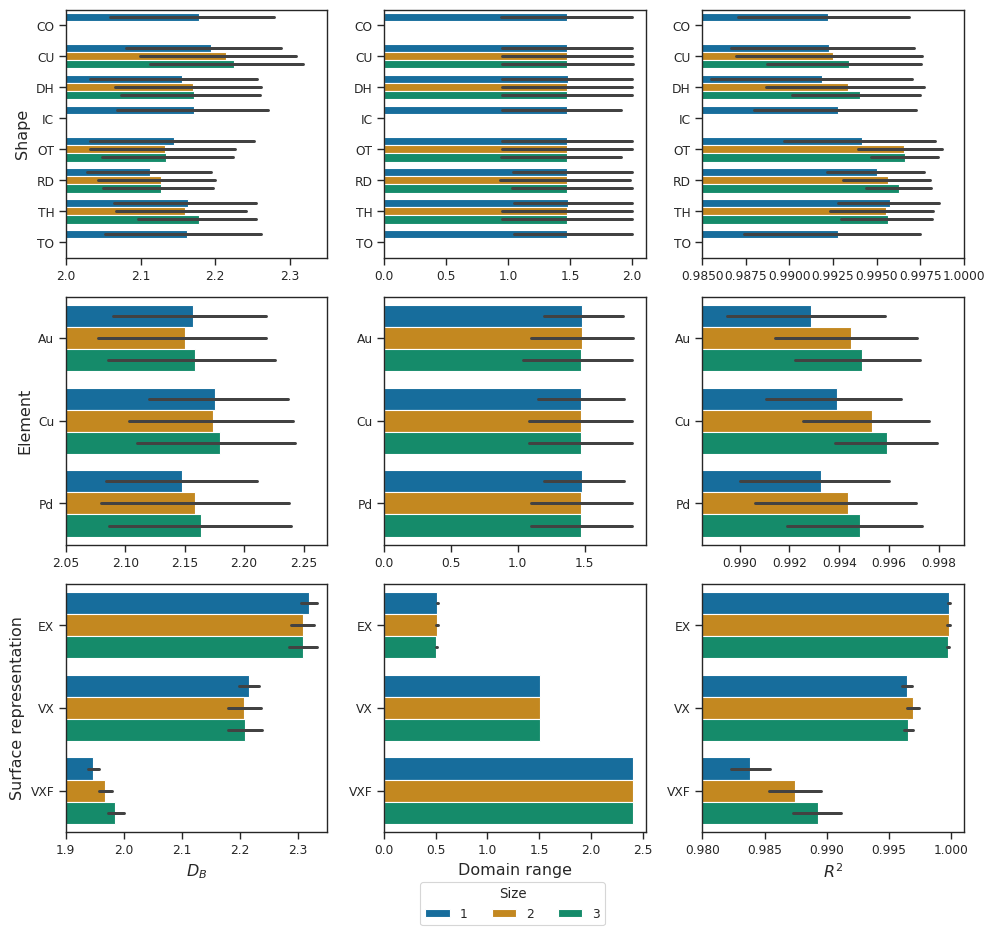

In [35]:
# Comparisons of the Box-Counting Results of Monometallic Nanoparticles Across Different Sizes
fig, axes = plt.subplots(3, 3, figsize=(10, 9), dpi=dpi)
g = sns.barplot(data=MNPsDF, x='DBox', y='shape', hue='size', ax=axes[0, 0])
axes[0, 0].set_xlim(left=2.0, right=2.35)
axes[0, 0].set_xlabel('')
axes[0, 0].set_ylabel('Shape', fontsize='large')
axes[0, 0].legend([],[], frameon=False)
g = sns.barplot(data=MNPsDF, x='rangeLen', y='shape', hue='size', ax=axes[0, 1])
axes[0, 1].set_xlabel('')
axes[0, 1].set_ylabel('')
axes[0, 1].legend([],[], frameon=False)
g = sns.barplot(data=MNPsDF, x='R2', y='shape', hue='size', ax=axes[0, 2])
axes[0, 2].set_xlim(left=0.985, right=1.00)
axes[0, 2].set_xlabel('')
axes[0, 2].set_ylabel('')
axes[0, 2].legend([],[], frameon=False)
g = sns.barplot(data=MNPsDF, x='DBox', y='element', hue='size', ax=axes[1, 0])
axes[1, 0].set_xlim(left=2.05, right=2.27)
axes[1, 0].set_xlabel('')
axes[1, 0].set_ylabel('Element', fontsize='large')
axes[1, 0].legend([],[], frameon=False)
g = sns.barplot(data=MNPsDF, x='rangeLen', y='element', hue='size', ax=axes[1, 1])
axes[1, 1].set_xlabel('')
axes[1, 1].set_ylabel('')
axes[1, 1].legend([],[], frameon=False)
g = sns.barplot(data=MNPsDF, x='R2', y='element', hue='size', ax=axes[1, 2])
axes[1, 2].set_xlim(left=0.9885, right=0.999)
axes[1, 2].set_xlabel('')
axes[1, 2].set_ylabel('')
axes[1, 2].legend([],[], frameon=False)
g = sns.barplot(data=MNPsDF, x='DBox', y='surfRep', hue='size', ax=axes[2, 0])
axes[2, 0].set_xlim(left=1.9, right=2.35)
axes[2, 0].set_xlabel(r'$D_B$', fontsize='large')
axes[2, 0].set_ylabel('Surface representation', fontsize='large')
axes[2, 0].legend([],[], frameon=False)
g = sns.barplot(data=MNPsDF, x='rangeLen', y='surfRep', hue='size', ax=axes[2, 1])
axes[2, 1].set_xlabel(r'Domain range', fontsize='large')
axes[2, 1].set_ylabel('')
axes[2, 1].legend([],[], frameon=False)
g = sns.barplot(data=MNPsDF, x='R2', y='surfRep', hue='size', ax=axes[2, 2])
axes[2, 2].set_xlim(left=0.98, right=1.001)
axes[2, 2].set_xlabel(r'$R^2$', fontsize='large')
axes[2, 2].set_ylabel('')
axes[2, 2].legend([],[], frameon=False)

legendHandle, _ = axes[0, 0].get_legend_handles_labels()
fig.legend(handles=legendHandle, title='Size', loc='lower center', bbox_to_anchor=(0.517, -0.04), ncol=3)
plt.tight_layout()
# g.savefig('figures/MNPsSizeAgg.png')

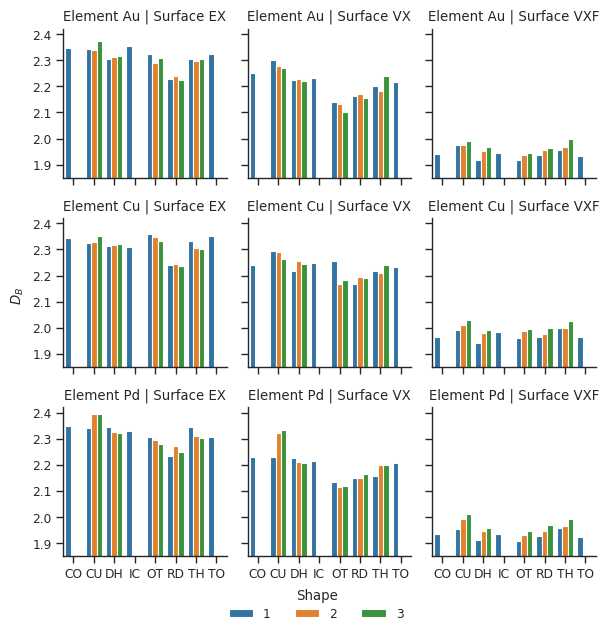

In [36]:
# Comparisons of the Box-Counting Dimensions of Monometallic Nanoparticles Across Different Sizes
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
        
    g = sns.FacetGrid(MNPsDF, row='element', col='surfRep', sharex=True, sharey=True, height=2, aspect=1)
    g.map_dataframe(sns.barplot, x='shape', y='DBox', hue='size', palette='tab10', errwidth=1.2, capsize=0.1)
    g.set(ylim=(1.85, 2.42))
    g.set_axis_labels('', '')
    g.set_titles(row_template='Element {row_name}', col_template='Surface {col_name}')
    g.figure.subplots_adjust(wspace=0, hspace=0)
    g.figure.text(0.355, 0.0, 'Shape', va='center')
    g.figure.text(-0.01, 0.5, r'$D_B$', va='center', rotation='vertical')
    g.add_legend(title='', loc='lower center', bbox_to_anchor=(0.38, -0.06), ncol=3)
    g.tight_layout()
    # g.savefig('figures/MNPsSizeDBox.png')

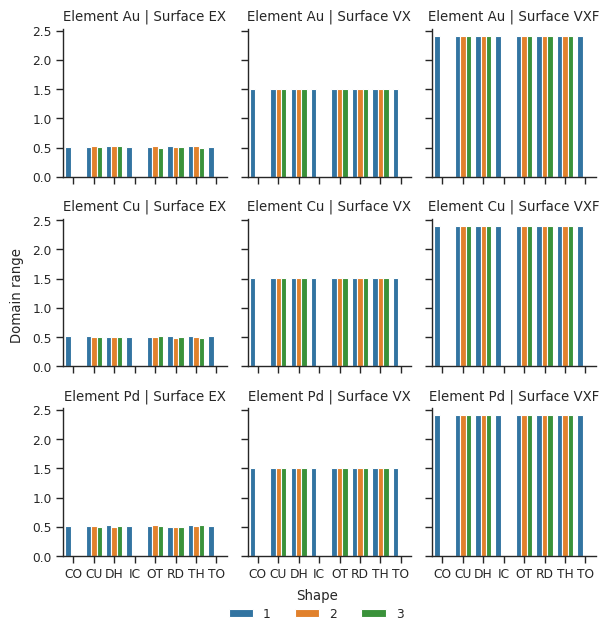

In [37]:
# Comparisons of the Domain Ranges of Monometallic Nanoparticles Across Different Sizes
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
        
    g = sns.FacetGrid(MNPsDF, row='element', col='surfRep', sharex=True, sharey=True, height=2, aspect=1)
    g.map_dataframe(sns.barplot, x='shape', y='rangeLen', hue='size', palette='tab10', errwidth=1.2, capsize=0.1)
    g.set_axis_labels('', '')
    g.set_titles(row_template='Element {row_name}', col_template='Surface {col_name}')
    g.figure.subplots_adjust(wspace=0, hspace=0)
    g.figure.text(0.355, 0.0, 'Shape', va='center')
    g.figure.text(-0.01, 0.5, 'Domain range', va='center', rotation='vertical')
    g.add_legend(title='', loc='lower center', bbox_to_anchor=(0.38, -0.06), ncol=3)
    g.tight_layout()
    # g.savefig('figures/MNPsSizeDomain.png')

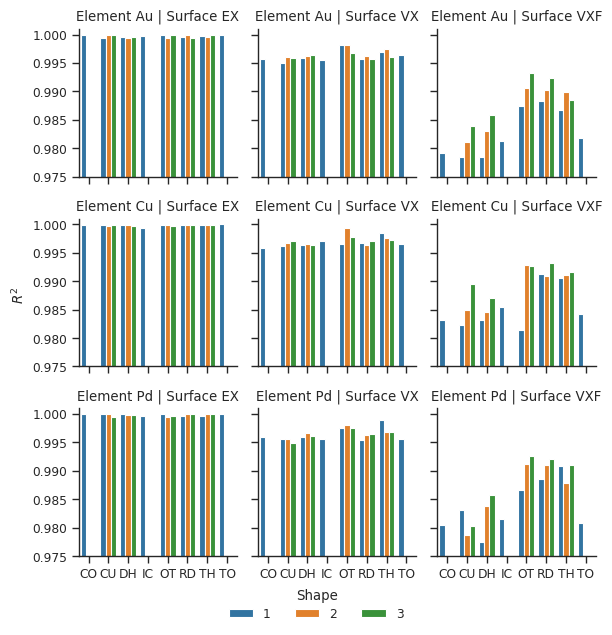

In [38]:
# Comparisons of the Coefficients of Determination of Monometallic Nanoparticles Across Different Sizes
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
        
    g = sns.FacetGrid(MNPsDF, row='element', col='surfRep', sharex=True, sharey=True, height=2, aspect=1)
    g.map_dataframe(sns.barplot, x='shape', y='R2', hue='size', palette='tab10', errwidth=1.2, capsize=0.1)
    g.set(ylim=(0.975, 1.001))
    g.set_axis_labels('', '')
    g.set_titles(row_template='Element {row_name}', col_template='Surface {col_name}')
    g.figure.subplots_adjust(wspace=0, hspace=0)
    g.figure.text(0.355, 0.0, 'Shape', va='center')
    g.figure.text(-0.01, 0.5, r'$R^2$', va='center', rotation='vertical')
    g.add_legend(title='', loc='lower center', bbox_to_anchor=(0.38, -0.06), ncol=3)
    g.tight_layout()
    # g.savefig('figures/MNPsSizeR2.png')

In [39]:
# fig, axes = plt.subplots(1, 3, figsize=(10, 3.5), sharey=True, dpi=dpi)
# g = sns.barplot(data=MNPsDF, x='DBox', y='shape', hue='size', ax=axes[0])
# axes[0].set_xlim(left=2.0, right=2.35)
# axes[0].set_xlabel(r'$D_B$', fontsize='large')
# axes[0].set_ylabel('Shape', fontsize='large')
# axes[0].legend([],[], frameon=False)
# g = sns.barplot(data=MNPsDF, x='rangeLen', y='shape', hue='size', ax=axes[1])
# axes[1].set_xlabel(r'Domain range', fontsize='large')
# axes[1].set_ylabel('')
# axes[1].legend([],[], frameon=False)
# g = sns.barplot(data=MNPsDF, x='R2', y='shape', hue='size', ax=axes[2])
# axes[2].set_xlim(left=0.985, right=1.00)
# axes[2].set_xlabel(r'$R^2$', fontsize='large')
# axes[2].set_ylabel('')
# axes[2].legend([],[], frameon=False)
# legendHandle, _ = axes[1].get_legend_handles_labels()
# fig.legend(handles=legendHandle, title='Size', loc='lower center', bbox_to_anchor=(0.523, -0.11), ncol=3)
# plt.tight_layout()
# # g.savefig('figures/MNPsSizeAggShape.png')

In [40]:
# fig, axes = plt.subplots(1, 3, figsize=(10, 3.5), sharey=True, dpi=dpi)
# g = sns.barplot(data=MNPsDF, x='DBox', y='element', hue='size', ax=axes[0])
# axes[0].set_xlim(left=2.05, right=2.27)
# axes[0].set_xlabel(r'$D_B$', fontsize='large')
# axes[0].set_ylabel('Size', fontsize='large')
# axes[0].legend([],[], frameon=False)
# g = sns.barplot(data=MNPsDF, x='rangeLen', y='element', hue='size', ax=axes[1])
# axes[1].set_xlabel(r'Domain range', fontsize='large')
# axes[1].set_ylabel('')
# axes[1].legend([],[], frameon=False)
# g = sns.barplot(data=MNPsDF, x='R2', y='element', hue='size', ax=axes[2])
# axes[2].set_xlim(left=0.9885, right=0.999)
# axes[2].set_xlabel(r'$R^2$', fontsize='large')
# axes[2].set_ylabel('')
# axes[2].legend([],[], frameon=False)
# legendHandle, _ = axes[1].get_legend_handles_labels()
# fig.legend(handles=legendHandle, title='Size', loc='lower center', bbox_to_anchor=(0.52, -0.11), ncol=3)
# plt.tight_layout()
# g.savefig('figures/MNPsSizeAggSize.png')

In [41]:
# fig, axes = plt.subplots(1, 3, figsize=(10, 3.5), sharey=True, dpi=dpi)
# g = sns.barplot(data=MNPsDF, x='DBox', y='surfRep', hue='size', ax=axes[0])
# axes[0].set_xlim(left=1.9, right=2.35)
# axes[0].set_xlabel(r'$D_B$', fontsize='large')
# axes[0].set_ylabel('Surface representation', fontsize='large')
# axes[0].legend([],[], frameon=False)
# g = sns.barplot(data=MNPsDF, x='rangeLen', y='surfRep', hue='size', ax=axes[1])
# axes[1].set_xlabel(r'Domain range', fontsize='large')
# axes[1].set_ylabel('')
# axes[1].legend([],[], frameon=False)
# g = sns.barplot(data=MNPsDF, x='R2', y='surfRep', hue='size', ax=axes[2])
# axes[2].set_xlim(left=0.98, right=1.001)
# axes[2].set_xlabel(r'$R^2$', fontsize='large')
# axes[2].set_ylabel('')
# axes[2].legend([],[], frameon=False)
# legendHandle, _ = axes[1].get_legend_handles_labels()
# fig.legend(handles=legendHandle, title='Size', loc='lower center', bbox_to_anchor=(0.523, -0.11), ncol=3)
# plt.tight_layout()
# # g.savefig('figures/MNPsSizeAggSurfRep.png')

#### Surface Specific Plots

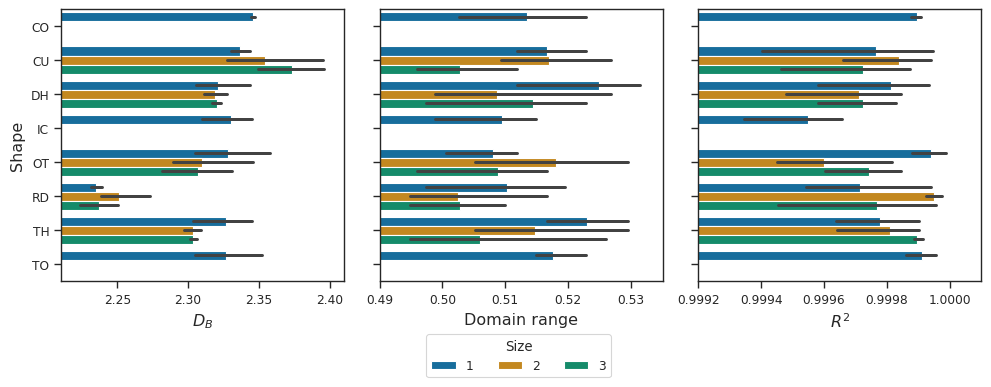

In [42]:
fig, axes = plt.subplots(1, 3, figsize=(10, 3.5), sharey=True, dpi=dpi)
g = sns.barplot(data=MNPsDF[MNPsDF['surfRep'] == 'EX'], x='DBox', y='shape', hue='size', ax=axes[0])
axes[0].set_xlim(left=2.21, right=2.41)
axes[0].set_xlabel(r'$D_B$', fontsize='large')
axes[0].set_ylabel('Shape', fontsize='large')
axes[0].legend([],[], frameon=False)
g = sns.barplot(data=MNPsDF[MNPsDF['surfRep'] == 'EX'], x='rangeLen', y='shape', hue='size', ax=axes[1])
axes[1].set_xlim(left=0.49, right=0.535)
axes[1].set_xlabel(r'Domain range', fontsize='large')
axes[1].set_ylabel('')
axes[1].legend([],[], frameon=False)
g = sns.barplot(data=MNPsDF[MNPsDF['surfRep'] == 'EX'], x='R2', y='shape', hue='size', ax=axes[2])
axes[2].set_xlim(left=0.9992, right=1.0001)
axes[2].set_xlabel(r'$R^2$', fontsize='large')
axes[2].set_ylabel('')
axes[2].legend([],[], frameon=False)
legendHandle, _ = axes[1].get_legend_handles_labels()
fig.legend(handles=legendHandle, title='Size', loc='lower center', bbox_to_anchor=(0.523, -0.11), ncol=3)
plt.tight_layout()
# g.savefig('figures/MNPsEXSizeAggShape.png')

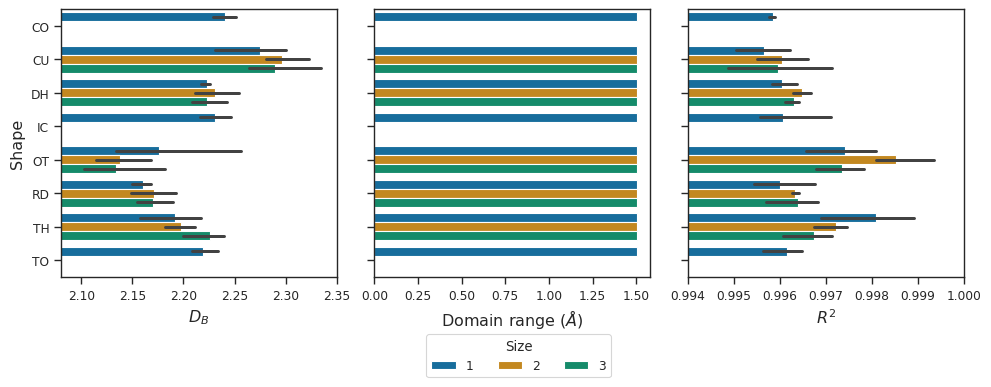

In [43]:
fig, axes = plt.subplots(1, 3, figsize=(10, 3.5), sharey=True, dpi=dpi)
g = sns.barplot(data=MNPsDF[MNPsDF['surfRep'] == 'VX'], x='DBox', y='shape', hue='size', ax=axes[0])
axes[0].set_xlim(left=2.08, right=2.35)
axes[0].set_xlabel(r'$D_B$', fontsize='large')
axes[0].set_ylabel('Shape', fontsize='large')
axes[0].legend([],[], frameon=False)
g = sns.barplot(data=MNPsDF[MNPsDF['surfRep'] == 'VX'], x='rangeLen', y='shape', hue='size', ax=axes[1])
axes[1].set_xlabel(r'Domain range ($\AA$)', fontsize='large')
axes[1].set_ylabel('')
axes[1].legend([],[], frameon=False)
g = sns.barplot(data=MNPsDF[MNPsDF['surfRep'] == 'VX'], x='R2', y='shape', hue='size', ax=axes[2])
axes[2].set_xlim(left=0.994, right=1.00)
axes[2].set_xlabel(r'$R^2$', fontsize='large')
axes[2].set_ylabel('')
axes[2].legend([],[], frameon=False)
legendHandle, _ = axes[1].get_legend_handles_labels()
fig.legend(handles=legendHandle, title='Size', loc='lower center', bbox_to_anchor=(0.523, -0.11), ncol=3)
plt.tight_layout()
# g.savefig('figures/MNPsVXSizeAggShape.png')

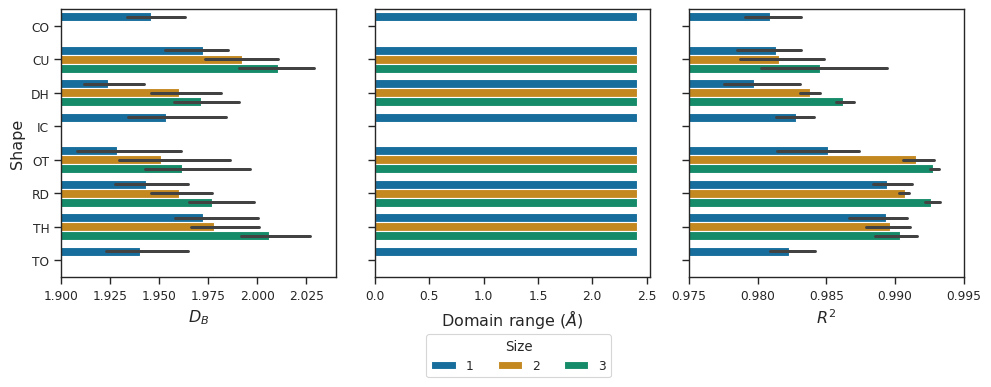

In [44]:
fig, axes = plt.subplots(1, 3, figsize=(10, 3.5), sharey=True, dpi=dpi)
g = sns.barplot(data=MNPsDF[MNPsDF['surfRep'] == 'VXF'], x='DBox', y='shape', hue='size', ax=axes[0])
axes[0].set_xlim(left=1.9, right=2.04)
axes[0].set_xlabel(r'$D_B$', fontsize='large')
axes[0].set_ylabel('Shape', fontsize='large')
axes[0].legend([],[], frameon=False)
g = sns.barplot(data=MNPsDF[MNPsDF['surfRep'] == 'VXF'], x='rangeLen', y='shape', hue='size', ax=axes[1])
axes[1].set_xlabel(r'Domain range ($\AA$)', fontsize='large')
axes[1].set_ylabel('')
axes[1].legend([],[], frameon=False)
g = sns.barplot(data=MNPsDF[MNPsDF['surfRep'] == 'VXF'], x='R2', y='shape', hue='size', ax=axes[2])
axes[2].set_xlim(left=0.975, right=0.995)
axes[2].set_xlabel(r'$R^2$', fontsize='large')
axes[2].set_ylabel('')
axes[2].legend([],[], frameon=False)
legendHandle, _ = axes[1].get_legend_handles_labels()
fig.legend(handles=legendHandle, title='Size', loc='lower center', bbox_to_anchor=(0.523, -0.11), ncol=3)
plt.tight_layout()
# g.savefig('figures/MNPsVXFElementAggShape.png')

### Comparisons Across Elements
Here we look at the aggregated plots of computed results ($D_B$ values, domain range, coefficient of determination $R^2$) comparing different elements, with different other factors being controlled.

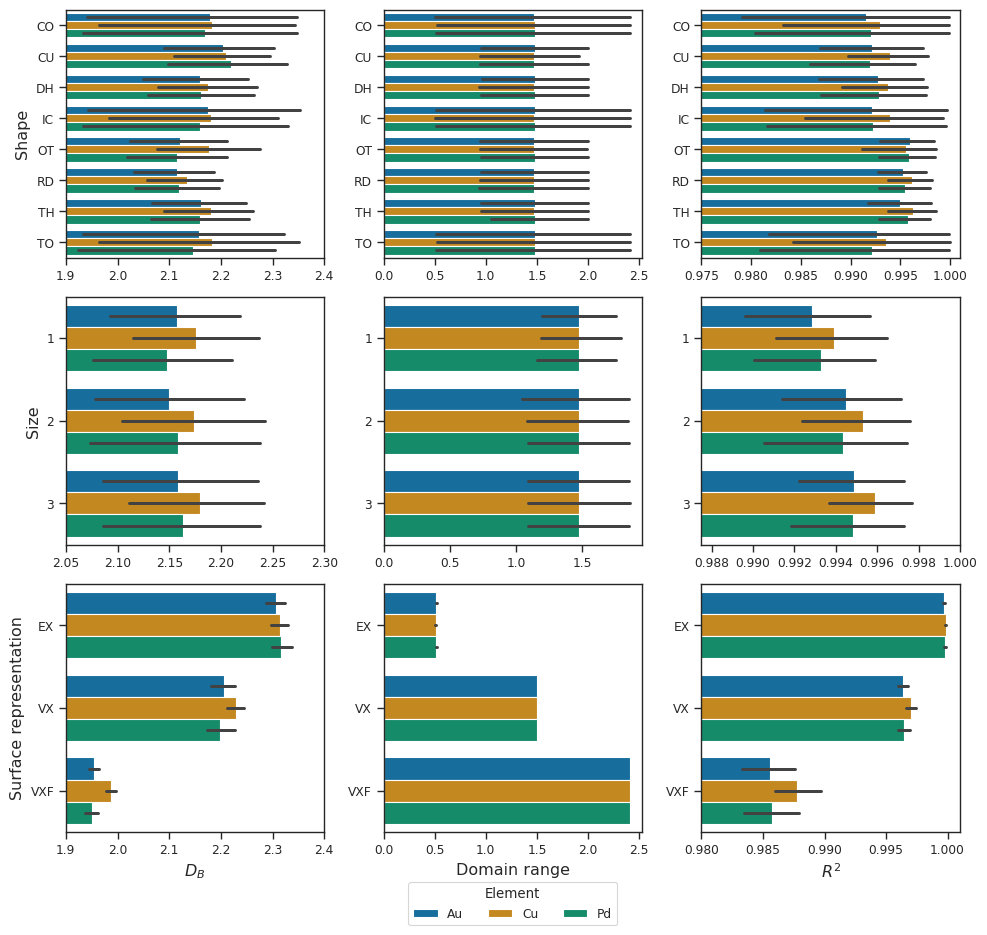

In [45]:
# Comparisons of the Box-Counting Results of Monometallic Nanoparticles Across Different Elements
fig, axes = plt.subplots(3, 3, figsize=(10, 9), dpi=dpi)
g = sns.barplot(data=MNPsDF, x='DBox', y='shape', hue='element', ax=axes[0, 0])
axes[0, 0].set_xlim(left=1.9, right=2.4)
axes[0, 0].set_xlabel('')
axes[0, 0].set_ylabel('Shape', fontsize='large')
axes[0, 0].legend([],[], frameon=False)
g = sns.barplot(data=MNPsDF, x='rangeLen', y='shape', hue='element', ax=axes[0, 1])
axes[0, 1].set_xlabel('')
axes[0, 1].set_ylabel('')
axes[0, 1].legend([],[], frameon=False)
g = sns.barplot(data=MNPsDF, x='R2', y='shape', hue='element', ax=axes[0, 2])
axes[0, 2].set_xlim(left=0.975, right=1.001)
axes[0, 2].set_xlabel('')
axes[0, 2].set_ylabel('')
axes[0, 2].legend([],[], frameon=False)
g = sns.barplot(data=MNPsDF, x='DBox', y='size', hue='element', ax=axes[1, 0])
axes[1, 0].set_xlim(left=2.05, right=2.3)
axes[1, 0].set_xlabel('')
axes[1, 0].set_ylabel('Size', fontsize='large')
axes[1, 0].legend([],[], frameon=False)
g = sns.barplot(data=MNPsDF, x='rangeLen', y='size', hue='element', ax=axes[1, 1])
axes[1, 1].set_xlabel('')
axes[1, 1].set_ylabel('')
axes[1, 1].legend([],[], frameon=False)
g = sns.barplot(data=MNPsDF, x='R2', y='size', hue='element', ax=axes[1, 2])
axes[1, 2].set_xlim(left=0.9875, right=1.00)
axes[1, 2].set_xlabel('')
axes[1, 2].set_ylabel('')
axes[1, 2].legend([],[], frameon=False)
g = sns.barplot(data=MNPsDF, x='DBox', y='surfRep', hue='element', ax=axes[2, 0])
axes[2, 0].set_xlim(left=1.9, right=2.4)
axes[2, 0].set_xlabel(r'$D_B$', fontsize='large')
axes[2, 0].set_ylabel('Surface representation', fontsize='large')
axes[2, 0].legend([],[], frameon=False)
g = sns.barplot(data=MNPsDF, x='rangeLen', y='surfRep', hue='element', ax=axes[2, 1])
axes[2, 1].set_xlabel(r'Domain range', fontsize='large')
axes[2, 1].set_ylabel('')
axes[2, 1].legend([],[], frameon=False)
g = sns.barplot(data=MNPsDF, x='R2', y='surfRep', hue='element', ax=axes[2, 2])
axes[2, 2].set_xlim(left=0.98, right=1.001)
axes[2, 2].set_xlabel(r'$R^2$', fontsize='large')
axes[2, 2].set_ylabel('')
axes[2, 2].legend([],[], frameon=False)

legendHandle, _ = axes[0, 0].get_legend_handles_labels()
fig.legend(handles=legendHandle, title='Element', loc='lower center', bbox_to_anchor=(0.517, -0.04), ncol=3)
plt.tight_layout()
# g.savefig('figures/MNPsElementAgg.png')

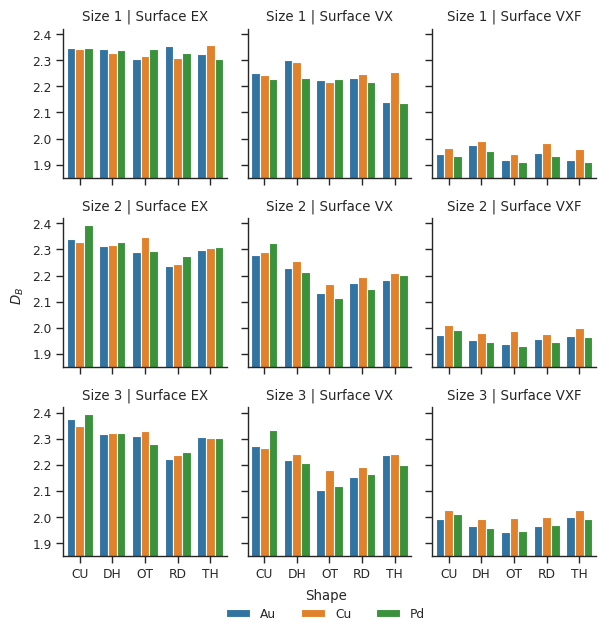

In [46]:
# Comparisons of the Box-Counting Dimensions of Monometallic Nanoparticles Across Different Elements
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
        
    g = sns.FacetGrid(MNPsDF, row='size', col='surfRep', sharex=True, sharey=True, height=2, aspect=1)
    g.map_dataframe(sns.barplot, x='shape', y='DBox', hue='element', palette='tab10', errwidth=1.2, capsize=0.1)
    g.set(ylim=(1.85, 2.42))
    g.set_axis_labels('', '')
    g.set_titles(row_template='Size {row_name}', col_template='Surface {col_name}')
    g.figure.subplots_adjust(wspace=0, hspace=0)
    g.figure.text(0.355, 0.0, 'Shape', va='center')
    g.figure.text(-0.01, 0.5, r'$D_B$', va='center', rotation='vertical')
    g.add_legend(title='', loc='lower center', bbox_to_anchor=(0.38, -0.06), ncol=3)
    g.tight_layout()
    # g.savefig('figures/MNPsElementDBox.png')

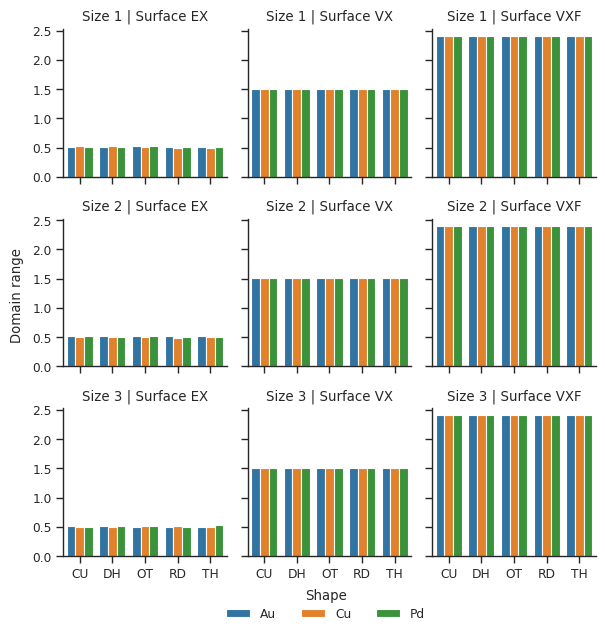

In [47]:
# Comparisons of the Domain Ranges of Monometallic Nanoparticles Across Different Elements
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
        
    g = sns.FacetGrid(MNPsDF, row='size', col='surfRep', sharex=True, sharey=True, height=2, aspect=1)
    g.map_dataframe(sns.barplot, x='shape', y='rangeLen', hue='element', palette='tab10', errwidth=1.2, capsize=0.1)
    g.set_axis_labels('', '')
    g.set_titles(row_template='Size {row_name}', col_template='Surface {col_name}')
    g.figure.subplots_adjust(wspace=0, hspace=0)
    g.figure.text(0.355, 0.0, 'Shape', va='center')
    g.figure.text(-0.01, 0.5, 'Domain range', va='center', rotation='vertical')
    g.add_legend(title='', loc='lower center', bbox_to_anchor=(0.38, -0.06), ncol=3)
    g.tight_layout()
    # g.savefig('figures/MNPsElementDomain.png')

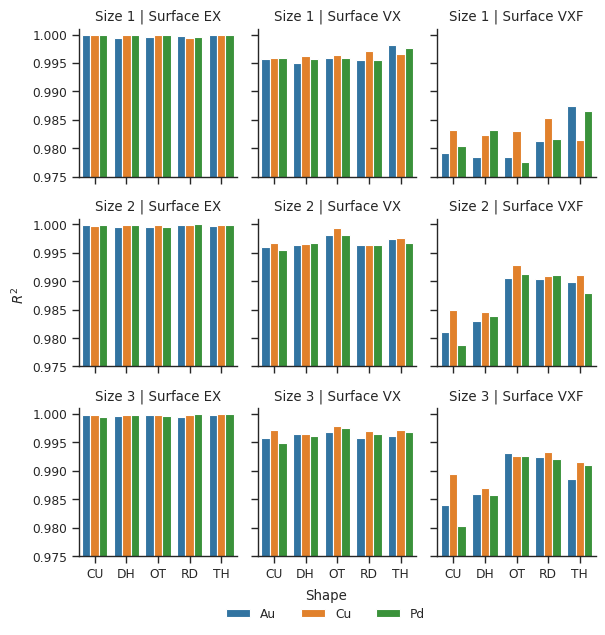

In [48]:
# Comparisons of the Coefficients of Determination of Monometallic Nanoparticles Across Different Elements
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
        
    g = sns.FacetGrid(MNPsDF, row='size', col='surfRep', sharex=True, sharey=True, height=2, aspect=1)
    g.map_dataframe(sns.barplot, x='shape', y='R2', hue='element', palette='tab10', errwidth=1.2, capsize=0.1)
    g.set(ylim=(0.975, 1.001))
    g.set_axis_labels('', '')
    g.set_titles(row_template='Size {row_name}', col_template='Surface {col_name}')
    g.figure.subplots_adjust(wspace=0, hspace=0)
    g.figure.text(0.355, 0.0, 'Shape', va='center')
    g.figure.text(-0.01, 0.5, r'$R^2$', va='center', rotation='vertical')
    g.add_legend(title='', loc='lower center', bbox_to_anchor=(0.38, -0.06), ncol=3)
    g.tight_layout()
    # g.savefig('figures/MNPsElementR2.png')

In [49]:
# fig, axes = plt.subplots(1, 3, figsize=(10, 3.5), sharey=True, dpi=dpi)
# g = sns.barplot(data=MNPsDF, x='DBox', y='shape', hue='element', ax=axes[0])
# axes[0].set_xlim(left=1.9, right=2.4)
# axes[0].set_xlabel(r'$D_B$', fontsize='large')
# axes[0].set_ylabel('Shape', fontsize='large')
# axes[0].legend([],[], frameon=False)
# g = sns.barplot(data=MNPsDF, x='rangeLen', y='shape', hue='element', ax=axes[1])
# axes[1].set_xlabel(r'Domain range', fontsize='large')
# axes[1].set_ylabel('')
# axes[1].legend([],[], frameon=False)
# g = sns.barplot(data=MNPsDF, x='R2', y='shape', hue='element', ax=axes[2])
# axes[2].set_xlim(left=0.975, right=1.001)
# axes[2].set_xlabel(r'$R^2$', fontsize='large')
# axes[2].set_ylabel('')
# axes[2].legend([],[], frameon=False)
# legendHandle, _ = axes[1].get_legend_handles_labels()
# fig.legend(handles=legendHandle, title='Element', loc='lower center', bbox_to_anchor=(0.523, -0.11), ncol=3)
# plt.tight_layout()
# # g.savefig('figures/MNPsElementAggShape.png')

In [50]:
# fig, axes = plt.subplots(1, 3, figsize=(10, 3.5), sharey=True, dpi=dpi)
# g = sns.barplot(data=MNPsDF, x='DBox', y='size', hue='element', ax=axes[0])
# axes[0].set_xlim(left=2.05, right=2.3)
# axes[0].set_xlabel(r'$D_B$', fontsize='large')
# axes[0].set_ylabel('Size', fontsize='large')
# axes[0].legend([],[], frameon=False)
# g = sns.barplot(data=MNPsDF, x='rangeLen', y='size', hue='element', ax=axes[1])
# axes[1].set_xlabel(r'Domain range', fontsize='large')
# axes[1].set_ylabel('')
# axes[1].legend([],[], frameon=False)
# g = sns.barplot(data=MNPsDF, x='R2', y='size', hue='element', ax=axes[2])
# axes[2].set_xlim(left=0.9875, right=1.00)
# axes[2].set_xlabel(r'$R^2$', fontsize='large')
# axes[2].set_ylabel('')
# axes[2].legend([],[], frameon=False)
# legendHandle, _ = axes[1].get_legend_handles_labels()
# fig.legend(handles=legendHandle, title='Element', loc='lower center', bbox_to_anchor=(0.52, -0.11), ncol=3)
# plt.tight_layout()
# g.savefig('figures/MNPsElementAggSize.png')

In [51]:
# fig, axes = plt.subplots(1, 3, figsize=(10, 3.5), sharey=True, dpi=dpi)
# g = sns.barplot(data=MNPsDF, x='DBox', y='surfRep', hue='element', ax=axes[0])
# axes[0].set_xlim(left=1.9, right=2.4)
# axes[0].set_xlabel(r'$D_B$', fontsize='large')
# axes[0].set_ylabel('Surface representation', fontsize='large')
# axes[0].legend([],[], frameon=False)
# g = sns.barplot(data=MNPsDF, x='rangeLen', y='surfRep', hue='element', ax=axes[1])
# axes[1].set_xlabel(r'Domain range', fontsize='large')
# axes[1].set_ylabel('')
# axes[1].legend([],[], frameon=False)
# g = sns.barplot(data=MNPsDF, x='R2', y='surfRep', hue='element', ax=axes[2])
# axes[2].set_xlim(left=0.98, right=1.001)
# axes[2].set_xlabel(r'$R^2$', fontsize='large')
# axes[2].set_ylabel('')
# axes[2].legend([],[], frameon=False)
# legendHandle, _ = axes[1].get_legend_handles_labels()
# fig.legend(handles=legendHandle, title='Element', loc='lower center', bbox_to_anchor=(0.523, -0.11), ncol=3)
# plt.tight_layout()
# # g.savefig('figures/MNPsElementAggSurfRep.png')

#### Surface Specific Plots

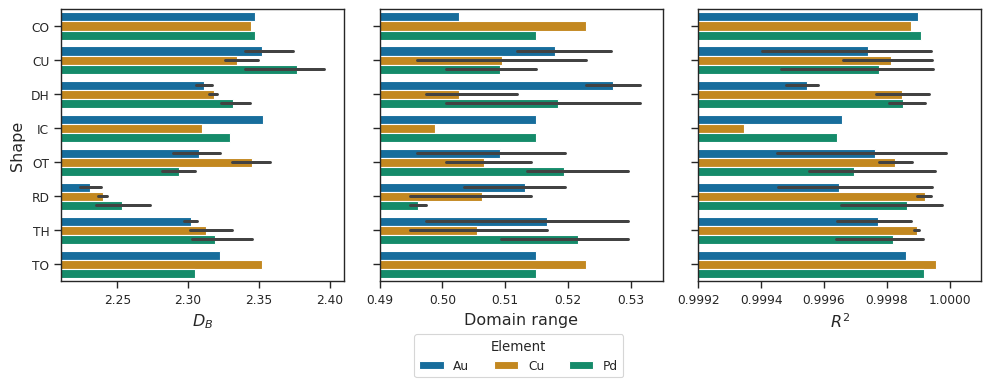

In [52]:
fig, axes = plt.subplots(1, 3, figsize=(10, 3.5), sharey=True, dpi=dpi)
g = sns.barplot(data=MNPsDF[MNPsDF['surfRep'] == 'EX'], x='DBox', y='shape', hue='element', ax=axes[0])
axes[0].set_xlim(left=2.21, right=2.41)
axes[0].set_xlabel(r'$D_B$', fontsize='large')
axes[0].set_ylabel('Shape', fontsize='large')
axes[0].legend([],[], frameon=False)
g = sns.barplot(data=MNPsDF[MNPsDF['surfRep'] == 'EX'], x='rangeLen', y='shape', hue='element', ax=axes[1])
axes[1].set_xlim(left=0.49, right=0.535)
axes[1].set_xlabel(r'Domain range', fontsize='large')
axes[1].set_ylabel('')
axes[1].legend([],[], frameon=False)
g = sns.barplot(data=MNPsDF[MNPsDF['surfRep'] == 'EX'], x='R2', y='shape', hue='element', ax=axes[2])
axes[2].set_xlim(left=0.9992, right=1.0001)
axes[2].set_xlabel(r'$R^2$', fontsize='large')
axes[2].set_ylabel('')
axes[2].legend([],[], frameon=False)
legendHandle, _ = axes[1].get_legend_handles_labels()
fig.legend(handles=legendHandle, title='Element', loc='lower center', bbox_to_anchor=(0.523, -0.11), ncol=3)
plt.tight_layout()
# g.savefig('figures/MNPsEXElementAggShape.png')

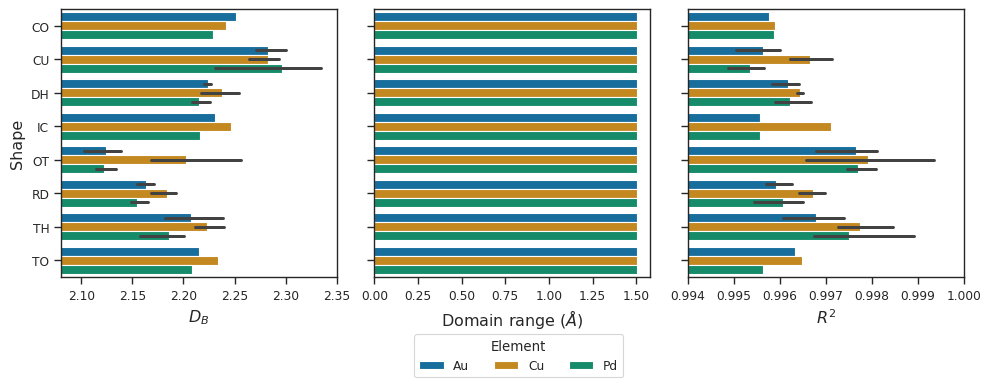

In [53]:
fig, axes = plt.subplots(1, 3, figsize=(10, 3.5), sharey=True, dpi=dpi)
g = sns.barplot(data=MNPsDF[MNPsDF['surfRep'] == 'VX'], x='DBox', y='shape', hue='element', ax=axes[0])
axes[0].set_xlim(left=2.08, right=2.35)
axes[0].set_xlabel(r'$D_B$', fontsize='large')
axes[0].set_ylabel('Shape', fontsize='large')
axes[0].legend([],[], frameon=False)
g = sns.barplot(data=MNPsDF[MNPsDF['surfRep'] == 'VX'], x='rangeLen', y='shape', hue='element', ax=axes[1])
axes[1].set_xlabel(r'Domain range ($\AA$)', fontsize='large')
axes[1].set_ylabel('')
axes[1].legend([],[], frameon=False)
g = sns.barplot(data=MNPsDF[MNPsDF['surfRep'] == 'VX'], x='R2', y='shape', hue='element', ax=axes[2])
axes[2].set_xlim(left=0.994, right=1.00)
axes[2].set_xlabel(r'$R^2$', fontsize='large')
axes[2].set_ylabel('')
axes[2].legend([],[], frameon=False)
legendHandle, _ = axes[1].get_legend_handles_labels()
fig.legend(handles=legendHandle, title='Element', loc='lower center', bbox_to_anchor=(0.523, -0.11), ncol=3)
plt.tight_layout()
# g.savefig('figures/MNPsVXElementAggShape.png')

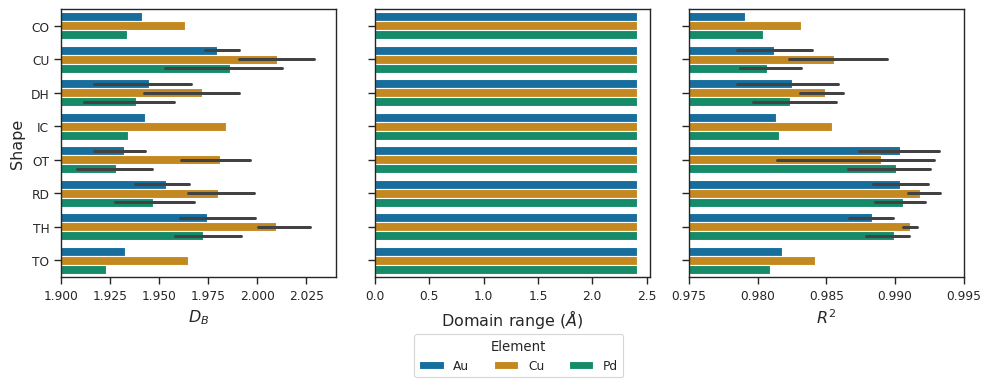

In [54]:
fig, axes = plt.subplots(1, 3, figsize=(10, 3.5), sharey=True, dpi=dpi)
g = sns.barplot(data=MNPsDF[MNPsDF['surfRep'] == 'VXF'], x='DBox', y='shape', hue='element', ax=axes[0])
axes[0].set_xlim(left=1.9, right=2.04)
axes[0].set_xlabel(r'$D_B$', fontsize='large')
axes[0].set_ylabel('Shape', fontsize='large')
axes[0].legend([],[], frameon=False)
g = sns.barplot(data=MNPsDF[MNPsDF['surfRep'] == 'VXF'], x='rangeLen', y='shape', hue='element', ax=axes[1])
axes[1].set_xlabel(r'Domain range ($\AA$)', fontsize='large')
axes[1].set_ylabel('')
axes[1].legend([],[], frameon=False)
g = sns.barplot(data=MNPsDF[MNPsDF['surfRep'] == 'VXF'], x='R2', y='shape', hue='element', ax=axes[2])
axes[2].set_xlim(left=0.975, right=0.995)
axes[2].set_xlabel(r'$R^2$', fontsize='large')
axes[2].set_ylabel('')
axes[2].legend([],[], frameon=False)
legendHandle, _ = axes[1].get_legend_handles_labels()
fig.legend(handles=legendHandle, title='Element', loc='lower center', bbox_to_anchor=(0.523, -0.11), ncol=3)
plt.tight_layout()
# g.savefig('figures/MNPsVXFElementAggShape.png')

<a id='bnps'></a>
## Comparison between Bimetallic Nanoparticles Trajectories

Here we compute the $D_B$ values of some bimetallic nanoparticles conformations obtained from the trajectories of a few classical molecular dynamics.

### Data Set

The data used here are obtained from collections of atomic coordinates of simulated nanoparticles generated for machine learning studies. Note that each conformation of nanoparticle has been energy-minimised.

The initial shapes of the bimetallic nanoparticles are chosen to match a few of those investigated and reported in [Bimetallic Pt–Pd nano-catalyst: size, shape and composition matter](https://doi.org/10.1088/1361-6528/ab1759) by Mendoza-Pérez and Guisbiers in 2019, namely tetrahedron (`TH`), octahedron (`OT`), cube (`CU`), and rhombic dodecahedron (`RD`). The publication indicated that `TH` and `CU` are the most catalytically active shapes, in accordance with the previous theoretical and experimental findings.

### Box-Counting Dimensions of Platinum-Palladium Nanoparticles

The evolution of the box-counting dimensions obtained from the exact surface representations of Pt-Pd nanoparticles over a melting process simulations are visualised below.

Each nanoparticle has a different combination of compositional and initial structural factors:
- Shapes:
    - cube (`CU`), enclosed by `{100}` facets,
    - rhombic dodecahedron (`RD`), enclosed by `{110}` facets, and
    - octahedron (`OT`) and tetrahedron (`TH`), enclosed by `{111}` facets.
- Pt-Pd elemental ratios:
    - `25:75`,
    - `50:50`, and
    - `75:25`.
- Ordering:
    - L$1_0$ Intermetallic (`L10`), 
    - L$1_2$ Intermetallic (`L12`), 
    - random alloy (`RAL`), and
    - randomised core-shell (`RCS`).

In [55]:
# Load data
BNPsEXDF = readPickle('data/bnpsEX.pickle')
BNPsEXDF['BNPname'] = BNPsEXDF.apply(lambda f: f['NPname'].split('min')[0], axis=1)
BNPsEXDF['shape'] = BNPsEXDF.apply(lambda f: f['BNPname'][6:8], axis=1)
BNPsEXDF['percPt'] = BNPsEXDF.apply(lambda f: f['BNPname'][8:10] if f['BNPname'][8:10].isnumeric() else '50', axis=1)
BNPsEXDF['ordering'] = BNPsEXDF.apply(lambda f: f['BNPname'][10:13] if len(f['BNPname']) > 13 else f['BNPname'][8:11], axis=1)
BNPsEXDF['timeStep'] = BNPsEXDF.apply(lambda f: f['NPname'].split('min')[1][:-3], axis=1)
BNPsEXDF['frameNum'] = BNPsEXDF.apply(lambda f: int(f['timeStep']) // 18000, axis=1)
BNPsEXDF.reset_index(inplace=True)
cols = ['BNPname', 'shape', 'percPt', 'ordering', 'timeStep', 'frameNum', 'DBoxEX', 'rangeLenEX']  # 'lowCIEX', 'upCIEX', 'minLenEX', 'maxLenEX', 'R2EX'
BNPsEXDF = BNPsEXDF[cols]
BNPsEXDF.head(3)

,BNPname,shape,percPt,ordering,timeStep,frameNum,DBoxEX,rangeLenEX
0,PtPd40CU25RAL0S2,CU,25,RAL,0,0,2.341959,0.753328
1,PtPd40CU25RAL0S2,CU,25,RAL,20000,1,2.440386,0.505150
2,PtPd40CU25RAL0S2,CU,25,RAL,40000,2,2.441685,0.505150


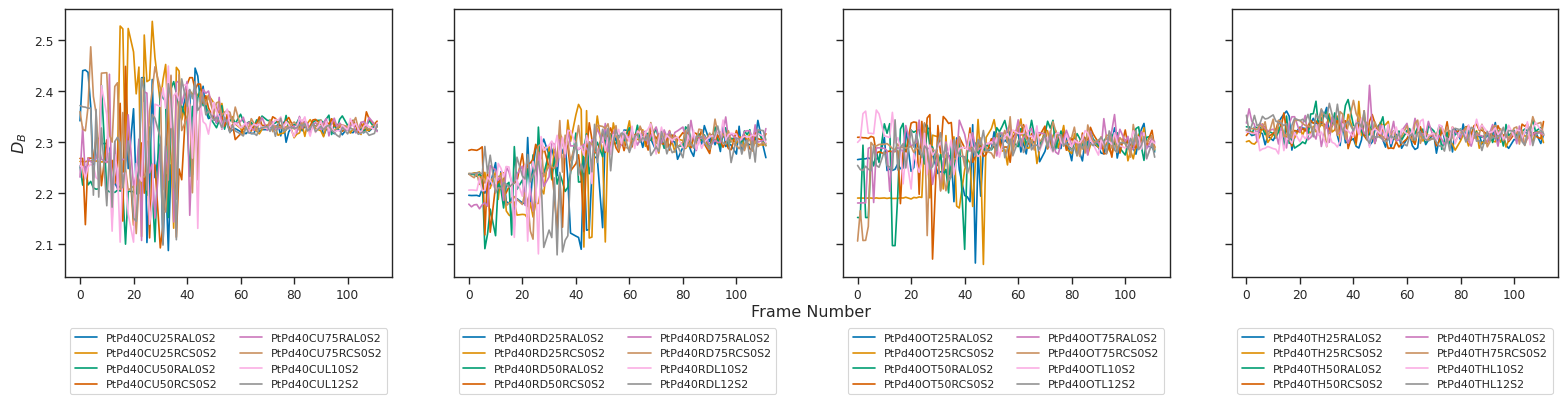

In [56]:
# Comparisons of the Changes in the Box-Counting Dimensions of PtPd Nanoparticles with Different Shapes in a Melting Process
fig, axes = plt.subplots(1, 4, figsize=(16, 4.5), sharex=True, sharey=True, dpi=dpi)
g = sns.lineplot(data=BNPsEXDF[BNPsEXDF['shape'] == 'CU'], x='frameNum', y='DBoxEX', hue='BNPname', ax=axes[0])
axes[0].set_xlabel('')
axes[0].set_ylabel(r'$D_B$', fontsize='large')
axes[0].legend(loc='lower center', bbox_to_anchor=(0.5, -0.46), ncol=2, fontsize='small')
g = sns.lineplot(data=BNPsEXDF[BNPsEXDF['shape'] == 'RD'], x='frameNum', y='DBoxEX', hue='BNPname', ax=axes[1])
axes[1].set_xlabel('')
axes[1].set_ylabel('')
axes[1].legend(loc='lower center', bbox_to_anchor=(0.5, -0.46), ncol=2, fontsize='small')
g = sns.lineplot(data=BNPsEXDF[BNPsEXDF['shape'] == 'OT'], x='frameNum', y='DBoxEX', hue='BNPname', ax=axes[2])
axes[2].set_xlabel('')
axes[2].set_ylabel('')
axes[2].legend(loc='lower center', bbox_to_anchor=(0.5, -0.46), ncol=2, fontsize='small')
g = sns.lineplot(data=BNPsEXDF[BNPsEXDF['shape'] == 'TH'], x='frameNum', y='DBoxEX', hue='BNPname', ax=axes[3])
axes[3].set_xlabel('')
axes[3].set_ylabel('')
axes[3].legend(loc='lower center', bbox_to_anchor=(0.5, -0.46), ncol=2, fontsize='small')
fig.text(0.472, 0.295, 'Frame Number', va='center', fontsize='large')
plt.tight_layout()
plt.savefig('figures/bnpDBoxShape.png')

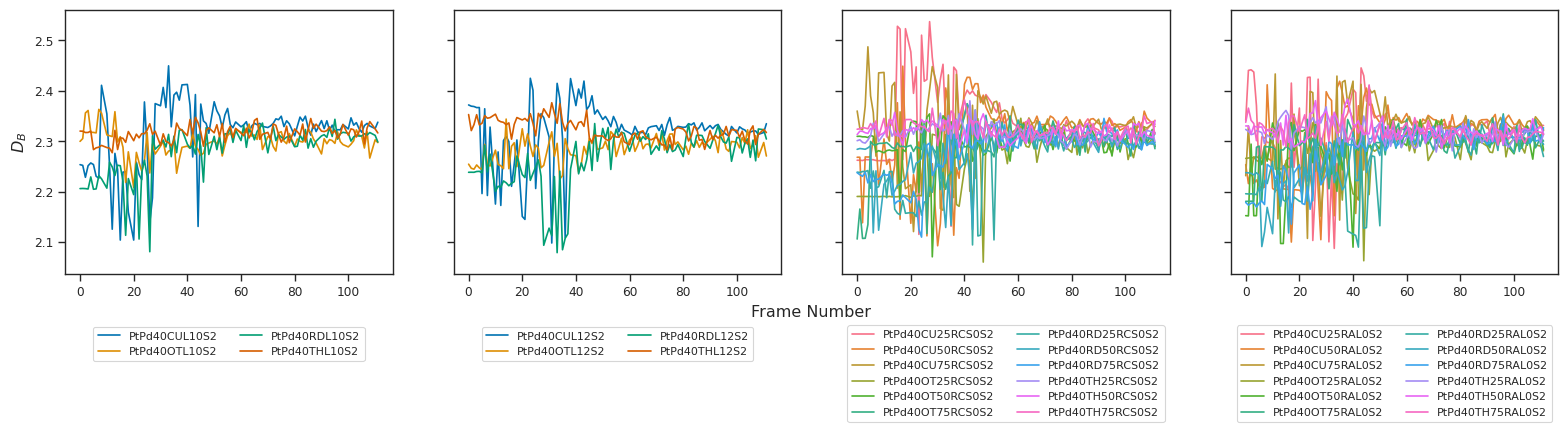

In [57]:
# Comparisons of the Changes in the Box-Counting Dimensions of PtPd Nanoparticles with Different Orderings in a Melting Process
fig, axes = plt.subplots(1, 4, figsize=(16, 5.2), sharex=True, sharey=True, dpi=dpi)
g = sns.lineplot(data=BNPsEXDF[BNPsEXDF['ordering'] == 'L10'], x='frameNum', y='DBoxEX', hue='BNPname', ax=axes[0])
axes[0].set_xlabel('')
axes[0].set_ylabel(r'$D_B$', fontsize='large')
axes[0].legend(loc='lower center', bbox_to_anchor=(0.5, -0.35), ncol=2, fontsize='small')
g = sns.lineplot(data=BNPsEXDF[BNPsEXDF['ordering'] == 'L12'], x='frameNum', y='DBoxEX', hue='BNPname', ax=axes[1])
axes[1].set_xlabel('')
axes[1].set_ylabel('')
axes[1].legend(loc='lower center', bbox_to_anchor=(0.5, -0.35), ncol=2, fontsize='small')
g = sns.lineplot(data=BNPsEXDF[BNPsEXDF['ordering'] == 'RCS'], x='frameNum', y='DBoxEX', hue='BNPname', ax=axes[2])
axes[2].set_xlabel('')
axes[2].set_ylabel('')
axes[2].legend(loc='lower center', bbox_to_anchor=(0.5, -0.58), ncol=2, fontsize='small')
g = sns.lineplot(data=BNPsEXDF[BNPsEXDF['ordering'] == 'RAL'], x='frameNum', y='DBoxEX', hue='BNPname', ax=axes[3])
axes[3].set_xlabel('')
axes[3].set_ylabel('')
axes[3].legend(loc='lower center', bbox_to_anchor=(0.5, -0.58), ncol=2, fontsize='small')
fig.text(0.472, 0.39, 'Frame Number', va='center', fontsize='large')
plt.tight_layout()
plt.savefig('figures/bnpDBoxOrdering.png')

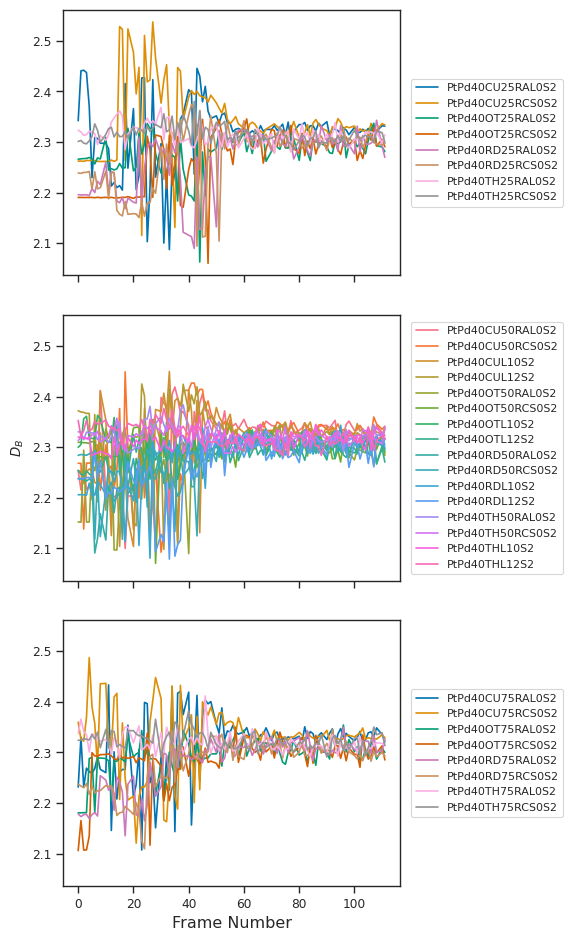

In [58]:
# Comparisons of the Changes in the Box-Counting Dimensions of PtPd Nanoparticles with Different Elemental Ratios in a Melting Process
fig, axes = plt.subplots(3, 1, figsize=(6.75, 9.5), sharex=True, sharey=True, dpi=dpi)
g = sns.lineplot(data=BNPsEXDF[BNPsEXDF['percPt'] == '25'], x='frameNum', y='DBoxEX', hue='BNPname', ax=axes[0])
axes[0].set_xlabel('')
axes[0].set_ylabel('', fontsize='large')
axes[0].legend(loc='center right', bbox_to_anchor=(1.5, 0.5), ncol=1, fontsize='small')
g = sns.lineplot(data=BNPsEXDF[BNPsEXDF['percPt'] == '50'], x='frameNum', y='DBoxEX', hue='BNPname', ax=axes[1])
axes[1].set_xlabel('')
axes[1].set_ylabel(r'$D_B$')
axes[1].legend(loc='right', bbox_to_anchor=(1.5, 0.5), ncol=1, fontsize='small')
g = sns.lineplot(data=BNPsEXDF[BNPsEXDF['percPt'] == '75'], x='frameNum', y='DBoxEX', hue='BNPname', ax=axes[2])
axes[2].set_xlabel('Frame Number', fontsize='large')
axes[2].set_ylabel('')
axes[2].legend(loc='center right', bbox_to_anchor=(1.5, 0.5), ncol=1, fontsize='small')
plt.tight_layout()
plt.savefig('figures/bnpDBoxPercPt.png')

### Moving Averages

As the noises obstruct proper observation of the underlying trends of the melting simulations, the moving averages are computed and visualised instead below.

In [59]:
# Compute moving averages
windowSize = 30

movingAvgs, bnpNames, frameNums = [], [], []
for bnpName in BNPsEXDF['BNPname'].unique():
    boxCntDims = BNPsEXDF[BNPsEXDF['BNPname'] == bnpName]['DBoxEX']
    movingAvg = np.convolve(boxCntDims, np.ones(windowSize)/windowSize, mode='valid')
    bnpName = [bnpName] * len(movingAvg)
    frames = list(range(len(movingAvg)))
    movingAvgs.extend(list(movingAvg))
    bnpNames.extend(bnpName)
    frameNums.extend(frames)
BNPsEXavgDF = pd.DataFrame(list(zip(bnpNames, frameNums, movingAvgs)), columns=['BNPname', 'frameNum', 'DBoxEX'])
BNPsEXavgDF['shape'] = BNPsEXavgDF.apply(lambda f: f['BNPname'][6:8], axis=1)
BNPsEXavgDF['percPt'] = BNPsEXavgDF.apply(lambda f: f['BNPname'][8:10] if f['BNPname'][8:10].isnumeric() else '50', axis=1)
BNPsEXavgDF['ordering'] = BNPsEXavgDF.apply(lambda f: f['BNPname'][10:13] if len(f['BNPname']) > 13 else f['BNPname'][8:11], axis=1)
BNPsEXavgDF.head(3)

,BNPname,frameNum,DBoxEX,shape,percPt,ordering
0,PtPd40CU25RAL0S2,0,2.291439,CU,25,RAL
1,PtPd40CU25RAL0S2,1,2.282955,CU,25,RAL
2,PtPd40CU25RAL0S2,2,2.276800,CU,25,RAL


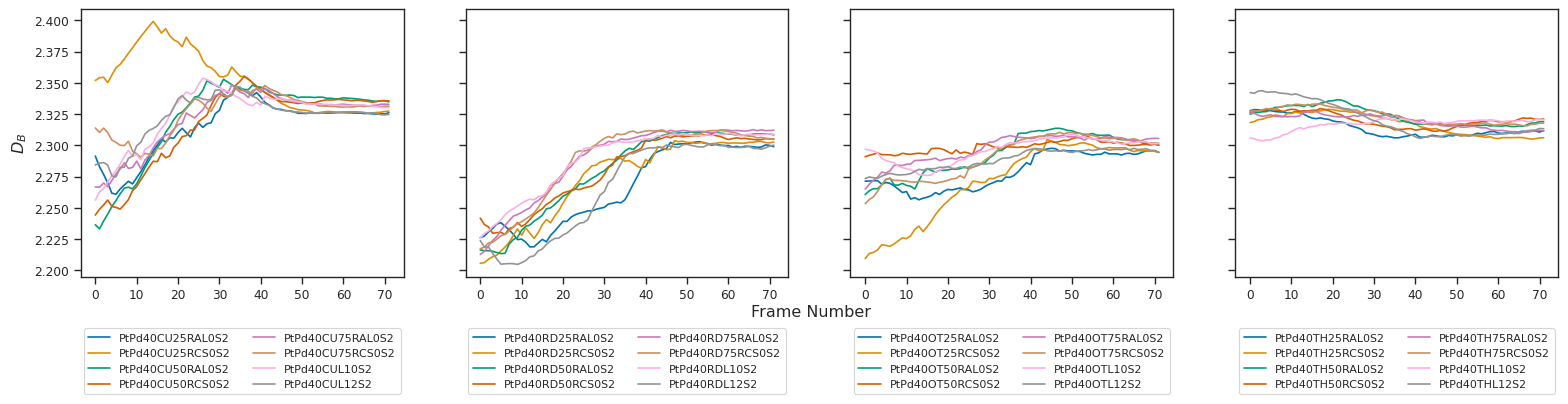

In [60]:
# Comparisons of the Changes in the Averaged Box-Counting Dimensions of PtPd Nanoparticles with Different Shapes in a Melting Process
fig, axes = plt.subplots(1, 4, figsize=(16, 4.5), sharex=True, sharey=True, dpi=dpi)
g = sns.lineplot(data=BNPsEXavgDF[BNPsEXavgDF['shape'] == 'CU'], x='frameNum', y='DBoxEX', hue='BNPname', ax=axes[0])
axes[0].set_xlabel('')
axes[0].set_ylabel(r'$D_B$', fontsize='large')
axes[0].legend(loc='lower center', bbox_to_anchor=(0.5, -0.46), ncol=2, fontsize='small')
g = sns.lineplot(data=BNPsEXavgDF[BNPsEXavgDF['shape'] == 'RD'], x='frameNum', y='DBoxEX', hue='BNPname', ax=axes[1])
axes[1].set_xlabel('')
axes[1].set_ylabel('')
axes[1].legend(loc='lower center', bbox_to_anchor=(0.5, -0.46), ncol=2, fontsize='small')
g = sns.lineplot(data=BNPsEXavgDF[BNPsEXavgDF['shape'] == 'OT'], x='frameNum', y='DBoxEX', hue='BNPname', ax=axes[2])
axes[2].set_xlabel('')
axes[2].set_ylabel('')
axes[2].legend(loc='lower center', bbox_to_anchor=(0.5, -0.46), ncol=2, fontsize='small')
g = sns.lineplot(data=BNPsEXavgDF[BNPsEXavgDF['shape'] == 'TH'], x='frameNum', y='DBoxEX', hue='BNPname', ax=axes[3])
axes[3].set_xlabel('')
axes[3].set_ylabel('')
axes[3].legend(loc='lower center', bbox_to_anchor=(0.5, -0.46), ncol=2, fontsize='small')
fig.text(0.472, 0.295, 'Frame Number', va='center', fontsize='large')
plt.tight_layout()
plt.savefig('figures/bnpDBoxAvgShape.png', bbox_inches='tight')

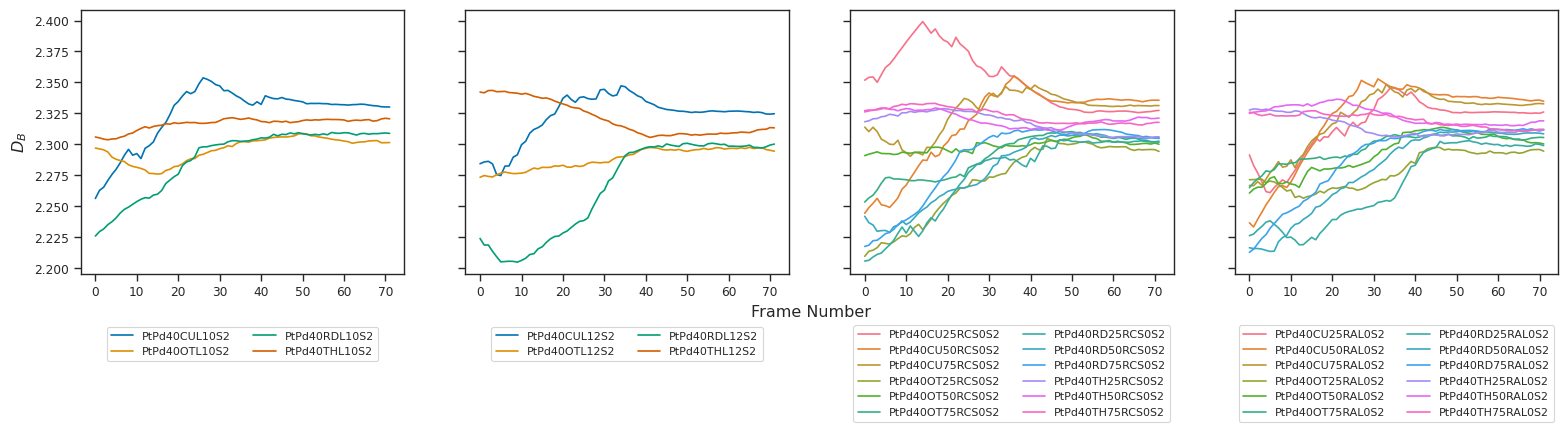

In [61]:
# Comparisons of the Changes in the Averaged Box-Counting Dimensions of PtPd Nanoparticles with Different Orderings in a Melting Process
fig, axes = plt.subplots(1, 4, figsize=(16, 5.2), sharex=True, sharey=True, dpi=dpi)
g = sns.lineplot(data=BNPsEXavgDF[BNPsEXavgDF['ordering'] == 'L10'], x='frameNum', y='DBoxEX', hue='BNPname', ax=axes[0])
axes[0].set_xlabel('')
axes[0].set_ylabel(r'$D_B$', fontsize='large')
axes[0].legend(loc='lower center', bbox_to_anchor=(0.5, -0.35), ncol=2, fontsize='small')
g = sns.lineplot(data=BNPsEXavgDF[BNPsEXavgDF['ordering'] == 'L12'], x='frameNum', y='DBoxEX', hue='BNPname', ax=axes[1])
axes[1].set_xlabel('')
axes[1].set_ylabel('')
axes[1].legend(loc='lower center', bbox_to_anchor=(0.5, -0.35), ncol=2, fontsize='small')
g = sns.lineplot(data=BNPsEXavgDF[BNPsEXavgDF['ordering'] == 'RCS'], x='frameNum', y='DBoxEX', hue='BNPname', ax=axes[2])
axes[2].set_xlabel('')
axes[2].set_ylabel('')
axes[2].legend(loc='lower center', bbox_to_anchor=(0.5, -0.58), ncol=2, fontsize='small')
g = sns.lineplot(data=BNPsEXavgDF[BNPsEXavgDF['ordering'] == 'RAL'], x='frameNum', y='DBoxEX', hue='BNPname', ax=axes[3])
axes[3].set_xlabel('')
axes[3].set_ylabel('')
axes[3].legend(loc='lower center', bbox_to_anchor=(0.5, -0.58), ncol=2, fontsize='small')
fig.text(0.472, 0.39, 'Frame Number', va='center', fontsize='large')
plt.tight_layout()
plt.savefig('figures/bnpDBoxAvgOrdering.png', bbox_inches='tight')

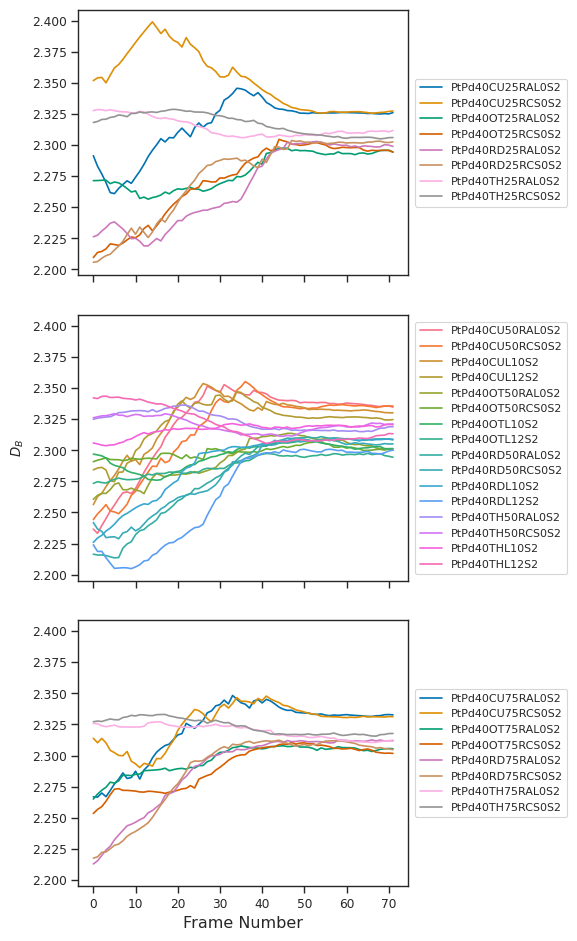

In [62]:
# Comparisons of the Changes in the Averaged Box-Counting Dimensions of PtPd Nanoparticles with Different Elemental Ratios in a Melting Process
fig, axes = plt.subplots(3, 1, figsize=(6.75, 9.5), sharex=True, sharey=True, dpi=dpi)
g = sns.lineplot(data=BNPsEXavgDF[BNPsEXavgDF['percPt'] == '25'], x='frameNum', y='DBoxEX', hue='BNPname', ax=axes[0])
axes[0].set_xlabel('')
axes[0].set_ylabel('', fontsize='large')
axes[0].legend(loc='center right', bbox_to_anchor=(1.5, 0.5), ncol=1, fontsize='small')
g = sns.lineplot(data=BNPsEXavgDF[BNPsEXavgDF['percPt'] == '50'], x='frameNum', y='DBoxEX', hue='BNPname', ax=axes[1])
axes[1].set_xlabel('')
axes[1].set_ylabel(r'$D_B$')
axes[1].legend(loc='right', bbox_to_anchor=(1.5, 0.5), ncol=1, fontsize='small')
g = sns.lineplot(data=BNPsEXavgDF[BNPsEXavgDF['percPt'] == '75'], x='frameNum', y='DBoxEX', hue='BNPname', ax=axes[2])
axes[2].set_xlabel('Frame Number', fontsize='large')
axes[2].set_ylabel('')
axes[2].legend(loc='center right', bbox_to_anchor=(1.5, 0.5), ncol=1, fontsize='small')
plt.tight_layout()
plt.savefig('figures/bnpDBoxAvgPercPt.png', bbox_inches='tight')

The ${D_B}_E$ values for `CU` and `TH` are consistently higher than `RD`. These observations match well with previous experimental and theoretical results from the literature, where `CU` and `TH` nanoparticles are deemed more catalytically active than `RD`, and indicate that this phenomenon is related to the roughness of the nanoparticle surfaces, i.e. the consistently lower ${D_B}_E$ values of the `RD` can be explained by its relatively lower surface-to-volume ratio, due to the inaccessible (or relatively harder to access) surface atoms in the `{110}` facet terraces.

The convergence to a ${D_B}_E$ of about $2.327$ for cubic nanoparticles and the rest of the nanoparticles to about $2.310$ has yet to be explained. An attempt made was to compute the ${D_B}_E$ of spherical nanoparticles of different sizes as cut out of an `FCC` packing. However, the results vary from $2.1170$ to $2.3222$ depending on the size. Matching the diameters of the nanoparticles narrows the variation to a range from $2.1966$ to $2.2320$. As the `FCC` regularity doesn't take the disorder in the bimetallic nanoparticles into account, the remainder could be said to be accounted for by the structural disorder due to the high temperature, and also the structural or packing mismatch between the two elements (Pt and Pd).

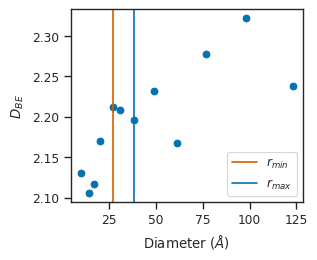

In [63]:
# Box-Counting Dimensions of Spherical Nanoparticles (Cut Out From FCC Crystals) of Different Diameters
sphereNPsDiameters = (10, 14, 17, 20, 27, 31, 38, 49, 61, 77, 98, 123)
sphereNPsDBoxs = (2.1310, 2.1056, 2.1170, 2.1702, 2.2127, 2.2088, 2.1966, 2.2320, 2.1673, 2.2776, 2.3222, 2.2387)
fig, ax = plt.subplots(figsize=(3, 2.5), dpi=dpi)
plt.scatter(sphereNPsDiameters, sphereNPsDBoxs)
plt.axvline(x=27, color='r', label=r'$r_{min}$')
plt.axvline(x=38, color='b', label=r'$r_{max}$')
plt.xlabel(r'Diameter ($\AA$)')
plt.ylabel(r'${D_B}_E$')
plt.legend()
plt.savefig('figures/sphereNPsDBox.png', bbox_inches='tight')